In [4]:
#!/usr/bin/env python3
"""
Sparse Autoencoder Interpretability Analysis
Visualizes decoder features, computes monosemanticity scores, and compares model configurations
"""

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.datasets import fetch_olivetti_faces, fetch_lfw_people
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import seaborn as sns
import math
from torch.utils.data import Dataset

class SparseAutoencoder(nn.Module):
    def __init__(self, input_size=784, hidden_size=64, k_top=20):
        super(SparseAutoencoder, self).__init__()
        self.training = True
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.k_top = k_top
        self.name = "Default Sparse Autoencoder"

        # Encoder maps input to hidden representation
        self.encoder = nn.Linear(input_size, hidden_size)

        # Decoder maps hidden representation back to input space
        self.decoder = nn.Linear(hidden_size, input_size)

    def _topk_mask(self, activations: torch.Tensor) -> torch.Tensor:
        # activations: (batch, hidden)
        k = max(0, min(self.k_top, activations.size(1)))
        _, idx = torch.topk(activations, k, dim=1)
        mask = torch.zeros_like(activations)
        mask.scatter_(1, idx, 1.0)
        return mask

    def forward(self, x):
        pre_activations = self.encoder(x)
        pre_activations = F.relu(pre_activations)
        mask = self._topk_mask(pre_activations)
        h = pre_activations * mask
        x_hat = self.decoder(h)
        return h, x_hat


    def compute_loss(self, x, h, x_hat):
        # We compute sum of squares and normalize by batch size
        recon_loss = torch.sum((x - x_hat) ** 2) / (x.size(0))

        return recon_loss

class SparseAutoencoderInit(SparseAutoencoder):
    def __init__(self, input_size=784, hidden_size=64, k_top=20):
        super(SparseAutoencoderInit, self).__init__(input_size, hidden_size, k_top)

        self.name = "Sparse Autoencoder with just weight initialization"
        # Initialize encoder weights first with random directions
        nn.init.kaiming_uniform_(self.encoder.weight, a=math.sqrt(5))
        # Initialize the decoder to be the transpose of the encoder weights
        with torch.no_grad():
            self.decoder.weight.copy_(self.encoder.weight.t())

class SparseAutoencoderAuxLoss(SparseAutoencoder):
    def __init__(self, input_size, hidden_size, k_top, k_aux, k_aux_param, dead_feature_threshold):
        super(SparseAutoencoderAuxLoss, self).__init__(input_size, hidden_size, k_top)
        self.name = "Sparse Autoencoder with Auxiliary Loss"
        # k_aux is typically 2*k or more to revive dead features
        self.k_aux = k_aux if k_aux is not None else 2 * k_top
        self.k_aux_param = k_aux_param
        # Track dead features: count steps since each feature was last active
        self.register_buffer('steps_since_active', torch.zeros(hidden_size))
        self.dead_feature_threshold = dead_feature_threshold

    # Function to track which features are dead
    def _update_dead_features(self, h: torch.Tensor):
        # Feature is active if ANY sample in batch activates it
        active_mask = (h.abs() > 1e-8).any(dim=0)

        # Increment counter for inactive features, reset for active ones
        self.steps_since_active += 1
        self.steps_since_active[active_mask] = 0

    def _get_dead_feature_mask(self) -> torch.Tensor:
        """Return boolean mask of dead features"""
        return self.steps_since_active > self.dead_feature_threshold

    def forward(self, x: torch.Tensor):
        h_raw = self.encoder(x)
        mask = self._topk_mask(h_raw)
        h = h_raw * mask
        x_hat = self.decoder(h)

        # Track dead features during training
        if self.training:
            self._update_dead_features(h)

        return h, x_hat

    def compute_loss(self, x, h, x_hat):

        recon_loss = torch.sum((x - x_hat) ** 2) / x.size(0)

        aux_loss = torch.tensor(0.0, device=x.device)

        if self.training:
            dead_mask = self._get_dead_feature_mask()
            n_dead = dead_mask.sum().item()

            if n_dead > 0:
                recon_error_vec = x - x_hat
                with torch.no_grad():
                    h_raw = F.relu(self.encoder(x))

                h_dead = h_raw * dead_mask.float().unsqueeze(0)
                k_aux_features = min(self.k_aux, n_dead)
                _, idx_aux = torch.topk(h_dead, k_aux_features, dim=1)
                mask_aux = torch.zeros_like(h_dead)
                mask_aux.scatter_(1, idx_aux, 1.0)

                z_aux = h_raw * mask_aux
                e_hat = self.decoder(z_aux)

                aux_loss = torch.sum((recon_error_vec - e_hat) ** 2) / x.size(0)
                aux_loss = aux_loss * self.k_aux_param

        total_loss = recon_loss + aux_loss
        return total_loss, recon_loss, aux_loss

class SparseAutoencoderComplete(SparseAutoencoder):
    def __init__(self, input_size, hidden_size, k_top, k_aux, k_aux_param, dead_feature_threshold, jump_value):
        super(SparseAutoencoderComplete, self).__init__(input_size, hidden_size, k_top)
        self.name = "Sparse Autoencoder with weight init., JumpReLU and Auxiliary Loss"
        self.jump_value = jump_value

        # k_aux is typically 2*k or more to revive dead features
        self.k_aux = k_aux if k_aux is not None else 2 * k_top
        self.k_aux_param = k_aux_param
        # Track dead features: count steps since each feature was last active
        self.register_buffer('steps_since_active', torch.zeros(hidden_size))
        self.dead_feature_threshold = dead_feature_threshold

        # Initialize encoder weights first with random directions
        nn.init.kaiming_uniform_(self.encoder.weight, a=math.sqrt(5))
        # Initialize the decoder to be the transpose of the encoder weights
        with torch.no_grad():
            self.decoder.weight.copy_(self.encoder.weight.t())

    # Function to track which features are dead
    def _update_dead_features(self, h: torch.Tensor):
        # Feature is active if ANY sample in batch activates it
        active_mask = (h.abs() > 1e-8).any(dim=0)

        # Increment counter for inactive features, reset for active ones
        self.steps_since_active += 1
        self.steps_since_active[active_mask] = 0

    def _get_dead_feature_mask(self) -> torch.Tensor:
        """Return boolean mask of dead features"""
        return self.steps_since_active > self.dead_feature_threshold

    def forward(self, x: torch.Tensor):
        pre_activations = self.encoder(x)
        pre_activations = F.relu(pre_activations)
        mask = self._topk_mask(pre_activations)
        h = pre_activations * mask
        x_hat = self.decoder(h)

        # Track dead features during training
        if self.training:
            self._update_dead_features(h)

        return h, x_hat

    def compute_loss(self, x, h, x_hat):
        # Main reconstruction loss
        recon_error = torch.sum((x - x_hat) ** 2)
        recon_loss = recon_error / x.size(0)

        # Auxiliary loss using dead features only
        aux_loss = torch.tensor(0.0, device=x.device)

        if self.training:
            dead_mask = self._get_dead_feature_mask()  # (hidden_size,)
            n_dead = dead_mask.sum().item()

            if n_dead > 0:
                # Compute reconstruction error: e = x - x_hat
                recon_error_vec = x - x_hat  # (batch, input_size)

                # Get raw activations again (before TopK masking)
                with torch.no_grad():
                    h_raw = self.encoder(x)

                # Select only dead features
                h_dead = h_raw * dead_mask.float().unsqueeze(0)  # (batch, hidden_size)

                # Select top-k_aux dead features
                k_aux_features = min(self.k_aux, n_dead)
                _, idx_aux = torch.topk(h_dead, k_aux_features, dim=1)
                mask_aux = torch.zeros_like(h_dead)
                mask_aux.scatter_(1, idx_aux, 1.0)

                # Sparse activations using only dead features
                z_aux = h_raw * mask_aux  # (batch, hidden_size)

                # Reconstruct error using dead features
                e_hat = self.decoder(z_aux)  # (batch, input_size)

                # Auxiliary loss: ||e - e_hat||^2
                aux_loss = torch.sum((recon_error_vec - e_hat) ** 2) / self.input_size

        # Total loss
        total_loss = recon_loss + self.k_aux_param * aux_loss

        return total_loss, recon_loss, aux_loss

def load_mnist_data(batch_size=256):
    # First load raw data to compute mean
    raw_transform = transforms.Compose([
        transforms.ToTensor(),  # Converts to [0,1] and creates tensor
    ])

    # Load training set to compute mean
    trainset_raw = torchvision.datasets.MNIST(root='./data', train=True,
                                              download=True, transform=raw_transform)

    # Compute mean over entire training set
    train_loader_temp = DataLoader(trainset_raw, batch_size=len(trainset_raw), shuffle=False)
    all_data = next(iter(train_loader_temp))[0]
    all_data = all_data.view(all_data.size(0), -1)  # Flatten to (N, 784)
    dataset_mean = all_data.mean(dim=0)  # Mean across samples, shape (784,)

    # Define preprocessing transform with mean subtraction and normalization
    def preprocess(x):
        x_flat = x.view(-1)  # Flatten from (1, 28, 28) to (784,)
        x_centered = x_flat - dataset_mean  # Subtract mean
        x_norm = x_centered / (torch.norm(x_centered) + 1e-8)  # Normalize to unit norm
        return x_norm

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(preprocess)
    ])

    # Load datasets with proper preprocessing
    trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transform)
    testset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True, transform=transform)

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, dataset_mean

def load_olivetti_data(batch_size=32, train_split=0.8):
    """
    Load Olivetti Faces dataset (400 images, 64x64 grayscale)
    Returns data with shape (N, 4096) after flattening
    """
    # Download Olivetti Faces using sklearn
    faces = fetch_olivetti_faces(shuffle=True, random_state=42)
    data = faces.data  # Already normalized to [0, 1], shape (400, 4096)

    # Convert to torch tensors
    data_tensor = torch.FloatTensor(data)  # Shape: (400, 4096)

    # Compute mean over entire dataset
    dataset_mean = data_tensor.mean(dim=0)  # Shape: (4096,)

    # Define preprocessing function
    def preprocess(x):
        x_centered = x - dataset_mean  # Subtract mean
        x_norm = x_centered / (torch.norm(x_centered) + 1e-8)  # Unit norm
        return x_norm

    # Apply preprocessing to all data
    preprocessed_data = torch.stack([preprocess(x) for x in data_tensor])

    # Create dataset (no labels needed for autoencoder)
    dataset = TensorDataset(preprocessed_data)

    # Split into train/test
    train_size = int(train_split * len(dataset))
    test_size = len(dataset) - train_size
    trainset, testset = random_split(dataset, [train_size, test_size],
                                     generator=torch.Generator().manual_seed(42))

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, dataset_mean

def load_lfw_data(batch_size=128, img_size=64, min_faces_per_person=20):
    """
    Load Labeled Faces in the Wild dataset with proper resizing

    Args:
        batch_size: Batch size
        img_size: Resize to (img_size, img_size) - actual pixels
        min_faces_per_person: Filter people with fewer images
    """
    # Download LFW with original size
    lfw_people = fetch_lfw_people(
        min_faces_per_person=min_faces_per_person,
        resize=1.0,  # Keep original size, we'll resize manually
        color=False
    )

    print(f"Original LFW shape: {lfw_people.images.shape}")

    # Manually resize to exact dimensions
    resized_images = []
    for img in lfw_people.images:
        # Convert to PIL Image for proper resizing
        pil_img = Image.fromarray((img * 255).astype(np.uint8))
        # Resize to exact target size
        pil_img = pil_img.resize((img_size, img_size), Image.LANCZOS)
        # Back to normalized array
        resized = np.array(pil_img).astype(np.float32) / 255.0
        resized_images.append(resized.flatten())

    data_flat = np.array(resized_images)
    print(f"Resized LFW shape: {data_flat.shape}")  # Should be (n_samples, img_size²)

    # Convert to torch
    data_tensor = torch.FloatTensor(data_flat)

    # Compute mean
    dataset_mean = data_tensor.mean(dim=0)

    # Preprocess
    def preprocess(x):
        x_centered = x - dataset_mean
        x_norm = x_centered / (torch.norm(x_centered) + 1e-8)
        return x_norm

    preprocessed_data = torch.stack([preprocess(x) for x in data_tensor])

    # Create dataset
    class LFWDataset(Dataset):
        def __init__(self, data):
            self.data = data

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return (self.data[idx],)

    dataset = LFWDataset(preprocessed_data)

    # Split 80/20
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    trainset, testset = random_split(dataset, [train_size, test_size],
                                     generator=torch.Generator().manual_seed(42))

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    print(f"LFW Dataset loaded: {len(trainset)} train, {len(testset)} test")
    print(f"Image size: {img_size}×{img_size}, Input dimension: {img_size**2}")

    return train_loader, test_loader, dataset_mean

def load_data(dataset_name, batch_size=128, img_size=64, **kwargs):
    """
    Unified data loading function for multiple datasets.

    Args:
        dataset_name: One of ['mnist', 'olivetti', 'lfw', 'imagenet']
        batch_size: Batch size for DataLoader
        img_size: Image size for face datasets (default 64)
        **kwargs: Additional dataset-specific arguments

    Returns:
        train_loader: DataLoader for training
        test_loader: DataLoader for testing
        dataset_mean: Mean vector used for preprocessing
    """

    if dataset_name.lower() == 'mnist':
        return load_mnist_data(batch_size)

    elif dataset_name.lower() == 'olivetti':
        train_split = kwargs.get('train_split', 0.8)
        return load_olivetti_data(batch_size, train_split)

    elif dataset_name.lower() == 'lfw':
        min_faces_per_person = kwargs.get('min_faces_per_person', 20)
        return load_lfw_data(batch_size, img_size, min_faces_per_person)

    else:
        raise ValueError(f"Unknown dataset: {dataset_name}. Choose from ['mnist', 'olivetti', 'lfw']")

def train_sparse_autoencoder(train_loader, num_epochs=50, learning_rate=0.001,
                            input_size=784, hidden_size=64, k_top=20,
                            JumpReLU=0.1, k_aux=None, k_aux_param=1/32,
                            dead_feature_threshold=1000, modelType="SAE",
                            dataset_type="mnist"):
    """
    Train sparse autoencoder with support for different datasets

    Args:
        train_loader: DataLoader for training data
        dataset_type: 'mnist', 'olivetti', or 'imagenet' to handle different unpacking
        ... (other args as before)
    """
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if modelType == "SAE":
        model = SparseAutoencoder(input_size=input_size, hidden_size=hidden_size, k_top=k_top).to(device)
    elif modelType == "SAE_Init":
        model = SparseAutoencoderInit(input_size=input_size, hidden_size=hidden_size, k_top=k_top).to(device)
    elif modelType == "SAE_AuxLoss":
        model = SparseAutoencoderAuxLoss(input_size=input_size, hidden_size=hidden_size, k_top=k_top, k_aux=k_aux,
                                         k_aux_param=k_aux_param, dead_feature_threshold=dead_feature_threshold).to(device)
    elif modelType == "Complete":
        model = SparseAutoencoderComplete(input_size=input_size, hidden_size=hidden_size, k_top=k_top, k_aux=k_aux,
                                         k_aux_param=k_aux_param, dead_feature_threshold=dead_feature_threshold, jump_value=JumpReLU).to(device)
    else:
        raise ValueError("Invalid modelType specified.")

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_aux_loss = 0.0
        running_mse = 0.0

        for data in train_loader:
            # Handle different data loader formats
            if dataset_type in ['olivetti', 'lfw']:
                # Olivetti returns single-element tuple: (inputs,)
                inputs, = data  # Note the comma - unpacks single element
                inputs = inputs.to(device)
            elif dataset_type in ['mnist', 'imagenet']:
                # MNIST and ImageNet return (inputs, labels)
                inputs, _ = data
                # No need to reshape - already preprocessed to correct shape
                inputs = inputs.to(device)
            else:
                raise ValueError(f"Unknown dataset_type: {dataset_type}")

            optimizer.zero_grad()
            h, outputs = model(inputs)



            if modelType == 'SAE_AuxLoss' or modelType == 'Complete':
                total_loss, mse_loss, aux_loss = model.compute_loss(inputs, h, outputs)
                loss = total_loss
                running_loss += total_loss.item()
                running_aux_loss += aux_loss.item()
                running_mse += mse_loss.item()
            else:
                loss = model.compute_loss(inputs, h, outputs)
                running_loss += loss.item()

            loss.backward()
            optimizer.step()

            # Clamp weights to enforce non-negativity
            with torch.no_grad():
                model.encoder.weight.clamp_(0.0)
                model.decoder.weight.clamp_(0.0)
        if modelType == 'SAE_AuxLoss' or modelType == 'Complete':
            print(f'Epoch [{epoch+1}/{num_epochs}], MSE Loss: {running_loss/len(train_loader):.4f}, Aux Loss: {running_aux_loss/len(train_loader):.4f}, Total Loss: {(running_loss + running_aux_loss)/len(train_loader):.4f}')
        else:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    print('Finished Training')
    return model

def count_dead_neurons(model, data_loader, dataset_type='mnist'):
    """
    Count dead neurons (features that never activate)

    Args:
        model: Trained SAE model
        data_loader: DataLoader with data
        dataset_type: 'mnist', 'olivetti', or 'imagenet' for proper unpacking

    Returns:
        num_dead: Number of dead neurons
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    dead_neurons = torch.ones(model.hidden_size, dtype=torch.bool).to(device)

    with torch.no_grad():
        for data in data_loader:
            # Handle different data loader formats
            if dataset_type in ['olivetti', 'lfw']:
                inputs, = data  # Single-element tuple
            else:  # mnist or imagenet
                inputs, _ = data  # (inputs, labels) tuple

            inputs = inputs.to(device)  # Already preprocessed, no reshape needed
            h, _ = model(inputs)

            # A neuron is alive if it activates (h > 0) for any sample
            dead_neurons &= (h.sum(dim=0) == 0)

    num_dead = dead_neurons.sum().item()
    model_name = getattr(model, 'name', 'SAE')
    print(f'Number of dead neurons in {model_name}: {num_dead} out of {model.hidden_size} '
          f'({100*num_dead/model.hidden_size:.2f}%)')
    return num_dead

def test_loss(model, data_loader, dataset_type='mnist'):
    """
    Compute average test loss

    Args:
        model: Trained SAE model
        data_loader: DataLoader with test data
        dataset_type: 'mnist', 'olivetti', or 'imagenet' for proper unpacking

    Returns:
        avg_loss: Average loss over test set
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for data in data_loader:
            # Handle different data loader formats
            if dataset_type in ['olivetti', 'lfw']:
                inputs, = data  # Single-element tuple
            else:  # mnist or imagenet
                inputs, _ = data  # (inputs, labels) tuple

            inputs = inputs.to(device)  # Already preprocessed, no reshape needed
            h, outputs = model(inputs)

            # Handle different loss outputs
            loss_output = model.compute_loss(inputs, h, outputs)
            if isinstance(loss_output, tuple):
                loss = loss_output[1]  # Extract MSE component
                total_loss += loss.item()
            else:
                loss = loss_output

            total_loss += loss.item()
            num_batches += 1

    avg_loss = total_loss / num_batches
    model_name = getattr(model, 'name', 'SAE')
    print(f'Test Loss for {model_name}: {avg_loss:.6f}')
    return avg_loss

def get_activation_statistics(model, data_loader, dataset_type='mnist'):
    """
    Get comprehensive statistics about feature activations
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    activation_counts = torch.zeros(model.hidden_size).to(device)
    activation_sums = torch.zeros(model.hidden_size).to(device)
    total_samples = 0

    with torch.no_grad():
        for data in data_loader:
            # Handle different data loader formats
            if dataset_type in ['olivetti', 'lfw']:
                inputs, = data
            else:
                inputs, _ = data

            inputs = inputs.to(device)
            h, _ = model(inputs)

            # Count how many times each feature activates (h > 0)
            activation_counts += (h > 0).sum(dim=0).float()
            activation_sums += h.sum(dim=0)
            total_samples += inputs.size(0)

    # Move to CPU for analysis
    activation_counts = activation_counts.cpu().numpy()
    activation_sums = activation_sums.cpu().numpy()

    # Compute statistics
    activation_freq = activation_counts / total_samples  # Fraction of samples each feature activates on

    # FIXED: Only compute mean over ACTIVE features (where count > 0)
    active_mask = activation_counts > 0
    mean_activation = np.zeros(model.hidden_size)
    mean_activation[active_mask] = activation_sums[active_mask] / activation_counts[active_mask]

    # Mean strength across ALL active features (not averaged over all samples)
    if np.sum(active_mask) > 0:
        mean_act_strength_active = np.mean(mean_activation[active_mask])
    else:
        mean_act_strength_active = 0.0

    stats = {
        'total_features': model.hidden_size,
        'dead_features': np.sum(activation_counts == 0),
        'active_features': np.sum(activation_counts > 0),
        'mean_activation_frequency': np.mean(activation_freq),
        'median_activation_frequency': np.median(activation_freq),
        'mean_activation_strength': mean_act_strength_active,  # Corrected calculation
        'activation_frequencies': activation_freq,
        'activation_strengths': mean_activation,
        'activation_counts': activation_counts
    }

    # Print summary
    model_name = getattr(model, 'name', 'SAE')
    print(f"\n=== Activation Statistics for {model_name} ===")
    print(f"Total features: {stats['total_features']}")
    print(f"Dead features: {stats['dead_features']} ({100*stats['dead_features']/stats['total_features']:.2f}%)")
    print(f"Active features: {stats['active_features']} ({100*stats['active_features']/stats['total_features']:.2f}%)")
    print(f"Mean activation frequency: {stats['mean_activation_frequency']:.4f}")
    print(f"Median activation frequency: {stats['median_activation_frequency']:.4f}")
    print(f"Mean activation strength (when active): {stats['mean_activation_strength']:.6f}")

    return stats

def plot_activation_histogram(model, data_loader, dataset_type='mnist'):
    """
    Plot histogram of feature activation frequencies

    Args:
        model: Trained SAE model
        data_loader: DataLoader with data
        dataset_type: 'mnist', 'olivetti', or 'imagenet'
    """
    stats = get_activation_statistics(model, data_loader, dataset_type)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    model_name = getattr(model, 'name', 'SAE')

    # Histogram of activation frequencies
    axes[0].hist(stats['activation_frequencies'], bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Activation Frequency (fraction of samples)')
    axes[0].set_ylabel('Number of Features')
    axes[0].set_title(f'{model_name}: Feature Activation Frequencies')
    axes[0].axvline(stats['mean_activation_frequency'], color='r', linestyle='--',
                    label=f'Mean: {stats["mean_activation_frequency"]:.4f}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Histogram of activation strengths (excluding dead features)
    active_strengths = stats['activation_strengths'][stats['activation_strengths'] > 0]
    axes[1].hist(active_strengths, bins=50, edgecolor='black', alpha=0.7, color='green')
    axes[1].set_xlabel('Mean Activation Strength')
    axes[1].set_ylabel('Number of Features')
    axes[1].set_title(f'{model_name}: Feature Activation Strengths (Active Features Only)')
    axes[1].axvline(stats['mean_activation_strength'], color='r', linestyle='--',
                    label=f'Mean: {stats["mean_activation_strength"]:.4f}')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



# Set random seeds for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seeds(42)

# Configuration for comprehensive experiments
experiment_configs = {
    'mnist': {
        'input_size': 784,
        'hidden_sizes': [128],
        'k_tops': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120],
        'batch_size': 256,
        'num_epochs': 50,
        'learning_rate': 0.001
    }
    ,
    'olivetti': {
        'input_size': 4096,
        'hidden_sizes': [256, 512, 1024],
        'k_tops': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120],
        'batch_size': 32,
        'num_epochs': 50,
        'learning_rate': 0.001
    },
    'lfw': {
        'input_size': 4096,  # 64x64 images
        'hidden_sizes': [512, 1024, 2048],
        'k_tops': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120],
        'batch_size': 64,
        'num_epochs': 50,
        'learning_rate': 0.001
    }
}




In [ ]:

# ============================================================================
# EXPERIMENT 1: Weight Initialization Comparison
# Tests: Random Xavier, Tied Weights, and Baseline
# Duration: ~4-6 hours for all datasets
# ============================================================================

# Helper function to safely get activation strength
def get_activation_strength_safe(activation_stats):
    """Safely extract mean activation strength, handling edge cases"""
    if 'mean_activation_strength' in activation_stats:
        strength = activation_stats['mean_activation_strength']
        # Handle NaN or infinite values
        if np.isnan(strength) or np.isinf(strength):
            return 0.0
        return float(strength)
    else:
        # If key doesn't exist, compute it manually
        activation_strengths = activation_stats.get('activation_strengths', np.array([]))
        if len(activation_strengths) > 0 and np.sum(activation_strengths > 0) > 0:
            return float(np.mean(activation_strengths[activation_strengths > 0]))
        return 0.0

# ============================================================================
# EXPERIMENT 1: Weight Initialization Comparison
# ============================================================================

print("=" * 80)
print("EXPERIMENT 1: WEIGHT INITIALIZATION COMPARISON")
print("=" * 80)

initialization_results = defaultdict(list)

for dataset_name in ['mnist', 'olivetti', 'lfw']:
    print(f"\n### Processing {dataset_name.upper()} Dataset ###")

    config = experiment_configs[dataset_name]

    # Load data
    train_loader, test_loader, dataset_mean = load_data(
        dataset_name,
        batch_size=config['batch_size'],
        img_size=64
    )

    for hidden_size in config['hidden_sizes']:
        for k_top in config['k_tops']:
            print(f"\nHidden Size: {hidden_size}, k_top: {k_top}")

            # Test 3 initialization strategies
            init_strategies = ['SAE', 'SAE_Init', 'SAE_AuxLoss', 'Complete']

            for strategy in init_strategies:
                print(f"  Training {strategy}...")
                set_seeds(42)  # Ensure reproducibility

                try:
                    # Train model
                    model = train_sparse_autoencoder(
                        train_loader=train_loader,
                        num_epochs=config['num_epochs'],
                        learning_rate=config['learning_rate'],
                        input_size=config['input_size'],
                        hidden_size=hidden_size,
                        k_top=k_top,
                        modelType=strategy,
                        dataset_type=dataset_name,
                        k_aux= 2 * k_top if strategy in ['SAE_AuxLoss', 'Complete'] else None,
                        k_aux_param= 0.1,
                        dead_feature_threshold=500
                    )

                    # Evaluate
                    test_loss_val = test_loss(model, test_loader, dataset_name)
                    dead_neurons_count = count_dead_neurons(model, train_loader, dataset_name)
                    activation_stats = get_activation_statistics(model, train_loader, dataset_name)

                    # Safely extract activation strength
                    mean_act_strength = get_activation_strength_safe(activation_stats)

                    # Store results
                    initialization_results['dataset'].append(dataset_name)
                    initialization_results['hidden_size'].append(hidden_size)
                    initialization_results['k_top'].append(k_top)
                    initialization_results['initialization'].append(strategy)
                    initialization_results['test_loss'].append(test_loss_val)
                    initialization_results['dead_neurons'].append(dead_neurons_count)
                    initialization_results['dead_neuron_pct'].append(
                        100 * dead_neurons_count / hidden_size
                    )
                    initialization_results['active_features'].append(
                        activation_stats['active_features']
                    )
                    initialization_results['mean_activation_freq'].append(
                        activation_stats['mean_activation_frequency']
                    )
                    initialization_results['mean_activation_strength'].append(mean_act_strength)

                    print(f"    Dead neurons: {dead_neurons_count}/{hidden_size} "
                          f"({100 * dead_neurons_count / hidden_size:.2f}%)")
                    print(f"    Test loss: {test_loss_val:.6f}")
                    print(f"    Mean activation strength: {mean_act_strength:.6f}")

                except Exception as e:
                    print(f"    ERROR training {strategy}: {str(e)}")
                    # Log error but continue with other experiments
                    continue

# Save results
df_init = pd.DataFrame(initialization_results)
df_init.to_csv('experiment1_initialization_results.csv', index=False)
print("\n✓ Experiment 1 results saved to 'experiment1_initialization_results.csv'")
print(f"  Total experiments completed: {len(df_init)}")

# ============================================================================
# EXPERIMENT 2: Auxiliary Loss Effects
# Tests: SAE with/without auxiliary loss
#
# ============================================================================

print("\n" + "=" * 80)
print("EXPERIMENT 2: AUXILIARY LOSS EFFECTS")
print("=" * 80)

auxloss_results = defaultdict(list)

for dataset_name in ['mnist', 'olivetti', 'lfw']:
    print(f"\n### Processing {dataset_name.upper()} Dataset ###")

    config = experiment_configs[dataset_name]

    # Load data
    train_loader, test_loader, dataset_mean = load_data(
        dataset_name,
        batch_size=config['batch_size'],
        img_size=64
    )

    for hidden_size in config['hidden_sizes']:
        k_top = config['k_tops'][1]  # Use middle k_top value

        print(f"\nHidden Size: {hidden_size}, k_top: {k_top}")

        # Test with and without auxiliary loss
        for use_aux_loss in [False, True]:
            model_type = 'SAE_AuxLoss' if use_aux_loss else 'SAE'
            print(f"  Training {'WITH' if use_aux_loss else 'WITHOUT'} auxiliary loss...")

            set_seeds(42)

            # Train model
            model = train_sparse_autoencoder(
                train_loader=train_loader,
                num_epochs=config['num_epochs'],
                learning_rate=config['learning_rate'],
                input_size=config['input_size'],
                hidden_size=hidden_size,
                k_top=k_top,
                modelType=model_type,
                dataset_type=dataset_name,
                k_aux=2 * k_top if use_aux_loss else None,
                k_aux_param= 0.1,
                dead_feature_threshold=500
            )

            # Evaluate
            test_loss_val = test_loss(model, test_loader, dataset_name)
            dead_neurons_count = count_dead_neurons(model, train_loader, dataset_name)
            activation_stats = get_activation_statistics(model, train_loader, dataset_name)

            # Store results
            auxloss_results['dataset'].append(dataset_name)
            auxloss_results['hidden_size'].append(hidden_size)
            auxloss_results['k_top'].append(k_top)
            auxloss_results['aux_loss'].append('Yes' if use_aux_loss else 'No')
            auxloss_results['test_loss'].append(test_loss_val)
            auxloss_results['dead_neurons'].append(dead_neurons_count)
            auxloss_results['dead_neuron_pct'].append(100 * dead_neurons_count / hidden_size)
            auxloss_results['active_features'].append(activation_stats['active_features'])
            auxloss_results['mean_activation_freq'].append(
                activation_stats['mean_activation_frequency']
            )

            print(f"    Dead neurons: {dead_neurons_count}/{hidden_size} "
                  f"({100 * dead_neurons_count / hidden_size:.2f}%)")

# Save results
df_aux = pd.DataFrame(auxloss_results)
df_aux.to_csv('experiment2_auxiliary_loss_results.csv', index=False)
print("\nExperiment 2 results saved to 'experiment2_auxiliary_loss_results.csv'")

# ============================================================================
# EXPERIMENT 3: Combined Effects (Init + AuxLoss)
# Tests all combinations
#
# ============================================================================

print("\n" + "=" * 80)
print("EXPERIMENT 3: COMBINED EFFECTS (Initialization + Auxiliary Loss)")
print("=" * 80)

combined_results = defaultdict(list)

for dataset_name in ['mnist', 'olivetti', 'lfw']:
    print(f"\n### Processing {dataset_name.upper()} Dataset ###")

    config = experiment_configs[dataset_name]

    # Load data
    train_loader, test_loader, dataset_mean = load_data(
        dataset_name,
        batch_size=config['batch_size'],
        img_size=64
    )

    hidden_size = config['hidden_sizes'][0]  # Use middle size
    k_top = config['k_tops'][1]

    print(f"\nHidden Size: {hidden_size}, k_top: {k_top}")

    # Test all combinations
    model_configs = [
        ('SAE', 'None', 'None'),
        ('SAE_Init', 'Tied', 'None'),
        ('SAE_AuxLoss', 'None', 'AuxLoss'),
        ('Complete', 'Tied', 'AuxLoss')
    ]

    for model_type, init_type, aux_type in model_configs:
        print(f"  Training {model_type}...")

        set_seeds(42)

        # Train model
        model = train_sparse_autoencoder(
            train_loader=train_loader,
            num_epochs=config['num_epochs'],
            learning_rate=config['learning_rate'],
            input_size=config['input_size'],
            hidden_size=hidden_size,
            k_top=k_top,
            modelType=model_type,
            dataset_type=dataset_name,
            k_aux=2 * k_top if 'AuxLoss' in aux_type else None,
            k_aux_param=1 / 32,
            dead_feature_threshold=200,
            JumpReLU=0.1
        )



        # Evaluate
        test_loss_val = test_loss(model, test_loader, dataset_name)
        dead_neurons_count = count_dead_neurons(model, train_loader, dataset_name)
        activation_stats = get_activation_statistics(model, train_loader, dataset_name)

        # Store results
        combined_results['dataset'].append(dataset_name)
        combined_results['model_type'].append(model_type)
        combined_results['initialization'].append(init_type)
        combined_results['auxiliary_loss'].append(aux_type)
        combined_results['test_loss'].append(test_loss_val)
        combined_results['dead_neurons'].append(dead_neurons_count)
        combined_results['dead_neuron_pct'].append(100 * dead_neurons_count / hidden_size)
        combined_results['active_features'].append(activation_stats['active_features'])

        print(f"    Dead neurons: {dead_neurons_count}/{hidden_size} "
              f"({100 * dead_neurons_count / hidden_size:.2f}%)")

# Save results
df_combined = pd.DataFrame(combined_results)
df_combined.to_csv('experiment3_combined_effects_results.csv', index=False)
print("\nExperiment 3 results saved to 'experiment3_combined_effects_results.csv'")

# ============================================================================
# FIGURE GENERATION: Publication-Quality Plots
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING PUBLICATION-QUALITY FIGURES")
print("=" * 80)

# Set style for publication
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")

# Figure 1: Dead Neuron Percentage by Initialization Strategy
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, dataset in enumerate(['mnist', 'olivetti', 'lfw']):
    df_subset = df_init[df_init['dataset'] == dataset]

    # Group by initialization and hidden size
    pivot_data = df_subset.pivot_table(
        values='dead_neuron_pct',
        index='hidden_size',
        columns='initialization',
        aggfunc='mean'
    )

    pivot_data.plot(kind='bar', ax=axes[idx], width=0.8)
    axes[idx].set_title(f'{dataset.upper()} Dataset', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Hidden Size', fontsize=12)
    axes[idx].set_ylabel('Dead Neurons (%)', fontsize=12)
    axes[idx].legend(title='Initialization', fontsize=10)
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_ylim([0, 100])

plt.tight_layout()
plt.savefig('figure1_dead_neurons_by_initialization.png', dpi=300, bbox_inches='tight')
plt.savefig('figure1_dead_neurons_by_initialization.pdf', bbox_inches='tight')
print("Saved: figure1_dead_neurons_by_initialization.png/pdf")
plt.close()

# Figure 2: Auxiliary Loss Impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Dead neuron percentage
ax = axes[0]
df_aux_grouped = df_aux.groupby(['dataset', 'aux_loss'])['dead_neuron_pct'].mean().reset_index()
pivot_aux = df_aux_grouped.pivot(index='dataset', columns='aux_loss', values='dead_neuron_pct')
pivot_aux.plot(kind='bar', ax=ax, width=0.7, color=['#d62728', '#2ca02c'])
ax.set_title('Dead Neuron Percentage\nWith/Without Auxiliary Loss', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Dead Neurons (%)', fontsize=12)
ax.legend(title='Auxiliary Loss', fontsize=10)
ax.grid(axis='y', alpha=0.3)

# Panel B: Test loss comparison
ax = axes[1]
df_loss_grouped = df_aux.groupby(['dataset', 'aux_loss'])['test_loss'].mean().reset_index()
pivot_loss = df_loss_grouped.pivot(index='dataset', columns='aux_loss', values='test_loss')
pivot_loss.plot(kind='bar', ax=ax, width=0.7, color=['#d62728', '#2ca02c'])
ax.set_title('Reconstruction Loss\nWith/Without Auxiliary Loss', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Test Loss (MSE)', fontsize=12)
ax.legend(title='Auxiliary Loss', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figure2_auxiliary_loss_effects.png', dpi=300, bbox_inches='tight')
plt.savefig('figure2_auxiliary_loss_effects.pdf', bbox_inches='tight')
print("Saved: figure2_auxiliary_loss_effects.png/pdf")
plt.close()

# Figure 3: Combined Effects Summary
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Panel A: Dead neurons by model type
ax = axes[0, 0]
df_combined_grouped = df_combined.groupby(['dataset', 'model_type'])['dead_neuron_pct'].mean().reset_index()
pivot_combined = df_combined_grouped.pivot(index='dataset', columns='model_type', values='dead_neuron_pct')
pivot_combined.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Dead Neuron Percentage by Model Configuration', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Dead Neurons (%)', fontsize=12)
ax.legend(title='Model Type', fontsize=9, loc='upper right')
ax.grid(axis='y', alpha=0.3)

# Panel B: Test loss by model type
ax = axes[0, 1]
df_loss_combined = df_combined.groupby(['dataset', 'model_type'])['test_loss'].mean().reset_index()
pivot_loss_combined = df_loss_combined.pivot(index='dataset', columns='model_type', values='test_loss')
pivot_loss_combined.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Reconstruction Loss by Model Configuration', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Test Loss (MSE)', fontsize=12)
ax.legend(title='Model Type', fontsize=9, loc='upper right')
ax.grid(axis='y', alpha=0.3)

# Panel C: Scatter plot - Dead neurons vs Test loss
ax = axes[1, 0]
for model_type in df_combined['model_type'].unique():
    df_model = df_combined[df_combined['model_type'] == model_type]
    ax.scatter(df_model['dead_neuron_pct'], df_model['test_loss'],
               label=model_type, s=100, alpha=0.7)
ax.set_xlabel('Dead Neurons (%)', fontsize=12)
ax.set_ylabel('Test Loss (MSE)', fontsize=12)
ax.set_title('Dead Neurons vs Reconstruction Performance', fontsize=14, fontweight='bold')
ax.legend(title='Model Type', fontsize=9)
ax.grid(alpha=0.3)

# Panel D: Active features comparison
ax = axes[1, 1]
df_active = df_combined.groupby(['dataset', 'model_type'])['active_features'].mean().reset_index()
pivot_active = df_active.pivot(index='dataset', columns='model_type', values='active_features')
pivot_active.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Active Feature Count by Model Configuration', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Number of Active Features', fontsize=12)
ax.legend(title='Model Type', fontsize=9)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figure3_combined_effects_summary.png', dpi=300, bbox_inches='tight')
plt.savefig('figure3_combined_effects_summary.pdf', bbox_inches='tight')
print("Saved: figure3_combined_effects_summary.png/pdf")
plt.close()

# Figure 4: Activation Statistics Histograms
# Compare best vs worst configurations
print("\nGenerating activation histograms for best/worst models...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, dataset in enumerate(['mnist', 'olivetti', 'lfw']):
    print(f"  Processing {dataset}...")

    config = experiment_configs[dataset]
    train_loader, test_loader, dataset_mean = load_data(
        dataset,
        batch_size=config['batch_size'],
        img_size=64
    )

    hidden_size = config['hidden_sizes'][1]
    k_top = config['k_tops'][1]

    # Train baseline (worst) and complete (best) models
    set_seeds(42)
    model_baseline = train_sparse_autoencoder(
        train_loader, num_epochs=config['num_epochs'],
        learning_rate=config['learning_rate'],
        input_size=config['input_size'], hidden_size=hidden_size,
        k_top=k_top, modelType='SAE', dataset_type=dataset
    )

    set_seeds(42)
    model_complete = train_sparse_autoencoder(
        train_loader, num_epochs=config['num_epochs'],
        learning_rate=config['learning_rate'],
        input_size=config['input_size'], hidden_size=hidden_size,
        k_top=k_top, modelType='Complete', dataset_type=dataset,
        k_aux=2 * k_top, k_aux_param=1 / 32, dead_feature_threshold=1000,
        JumpReLU=0.1
    )

    # Get activation statistics
    stats_baseline = get_activation_statistics(model_baseline, train_loader, dataset)
    stats_complete = get_activation_statistics(model_complete, train_loader, dataset)

    # Plot histograms
    ax = axes[0, idx]
    ax.hist(stats_baseline['activation_frequencies'], bins=50, alpha=0.6,
            label='Baseline SAE', color='red', edgecolor='black')
    ax.hist(stats_complete['activation_frequencies'], bins=50, alpha=0.6,
            label='Complete SAE', color='green', edgecolor='black')
    ax.set_xlabel('Activation Frequency', fontsize=11)
    ax.set_ylabel('Number of Features', fontsize=11)
    ax.set_title(f'{dataset.upper()}: Activation Frequencies', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

    ax = axes[1, idx]
    active_base = stats_baseline['activation_strengths'][stats_baseline['activation_strengths'] > 0]
    active_complete = stats_complete['activation_strengths'][stats_complete['activation_strengths'] > 0]
    ax.hist(active_base, bins=50, alpha=0.6, label='Baseline SAE',
            color='red', edgecolor='black')
    ax.hist(active_complete, bins=50, alpha=0.6, label='Complete SAE',
            color='green', edgecolor='black')
    ax.set_xlabel('Mean Activation Strength', fontsize=11)
    ax.set_ylabel('Number of Features', fontsize=11)
    ax.set_title(f'{dataset.upper()}: Activation Strengths', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figure4_activation_histograms.png', dpi=300, bbox_inches='tight')
plt.savefig('figure4_activation_histograms.pdf', bbox_inches='tight')
print("Saved: figure4_activation_histograms.png/pdf")
plt.close()

# ============================================================================
# Generate Summary Statistics Table (LaTeX format)
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING SUMMARY STATISTICS TABLE")
print("=" * 80)

# Create comprehensive summary table
summary_stats = []

for dataset in ['mnist', 'olivetti', 'lfw']:
    for model_type in ['SAE', 'SAE_Init', 'SAE_AuxLoss', 'Complete']:
        df_subset = df_combined[
            (df_combined['dataset'] == dataset) &
            (df_combined['model_type'] == model_type)
            ]

        if len(df_subset) > 0:
            summary_stats.append({
                'Dataset': dataset.upper(),
                'Model': model_type,
                'Dead (%)': f"{df_subset['dead_neuron_pct'].mean():.2f} ± {df_subset['dead_neuron_pct'].std():.2f}",
                'Test Loss': f"{df_subset['test_loss'].mean():.6f} ± {df_subset['test_loss'].std():.6f}",
                'Active Features': f"{df_subset['active_features'].mean():.0f}"
            })

df_summary = pd.DataFrame(summary_stats)

# Save as CSV
df_summary.to_csv('summary_statistics.csv', index=False)
print("Saved: summary_statistics.csv")

# Save as LaTeX table
latex_table = df_summary.to_latex(index=False, escape=False, column_format='lllll')
with open('results/dead neurons/summary_statistics.tex', 'w') as f:
    f.write(latex_table)
print("Saved: summary_statistics.tex")

# Print to console
print("\nSummary Statistics:")
print(df_summary.to_string(index=False))

print("\n" + "=" * 80)
print("ALL EXPERIMENTS COMPLETED SUCCESSFULLY")
print("=" * 80)
print("\nGenerated Files:")
print("  - experiment1_initialization_results.csv")
print("  - experiment2_auxiliary_loss_results.csv")
print("  - experiment3_combined_effects_results.csv")
print("  - figure1_dead_neurons_by_initialization.png/pdf")
print("  - figure2_auxiliary_loss_effects.png/pdf")
print("  - figure3_combined_effects_summary.png/pdf")
print("  - figure4_activation_histograms.png/pdf")
print("  - summary_statistics.csv")
print("  - summary_statistics.tex")

In [ ]:

# ============================================================================
# FIGURE GENERATION: Publication-Quality Plots
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING PUBLICATION-QUALITY FIGURES")
print("=" * 80)

# Set style for publication
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")

# Figure 1: Dead Neuron Percentage by Initialization Strategy
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, dataset in enumerate(['mnist', 'olivetti', 'lfw']):
    df_subset = df_init[df_init['dataset'] == dataset]

    # Group by initialization and hidden size
    pivot_data = df_subset.pivot_table(
        values='dead_neuron_pct',
        index='hidden_size',
        columns='initialization',
        aggfunc='mean'
    )

    pivot_data.plot(kind='bar', ax=axes[idx], width=0.8)
    axes[idx].set_title(f'{dataset.upper()} Dataset', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Hidden Size', fontsize=12)
    axes[idx].set_ylabel('Dead Neurons (%)', fontsize=12)
    axes[idx].legend(title='Initialization', fontsize=10)
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_ylim([0, 100])

plt.tight_layout()
plt.savefig('figure1_dead_neurons_by_initialization.png', dpi=300, bbox_inches='tight')
plt.savefig('figure1_dead_neurons_by_initialization.pdf', bbox_inches='tight')
print("Saved: figure1_dead_neurons_by_initialization.png/pdf")
plt.close()

# Figure 2: Auxiliary Loss Impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Dead neuron percentage
ax = axes[0]
df_aux_grouped = df_aux.groupby(['dataset', 'aux_loss'])['dead_neuron_pct'].mean().reset_index()
pivot_aux = df_aux_grouped.pivot(index='dataset', columns='aux_loss', values='dead_neuron_pct')
pivot_aux.plot(kind='bar', ax=ax, width=0.7, color=['#d62728', '#2ca02c'])
ax.set_title('Dead Neuron Percentage\nWith/Without Auxiliary Loss', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Dead Neurons (%)', fontsize=12)
ax.legend(title='Auxiliary Loss', fontsize=10)
ax.grid(axis='y', alpha=0.3)

# Panel B: Test loss comparison
ax = axes[1]
df_loss_grouped = df_aux.groupby(['dataset', 'aux_loss'])['test_loss'].mean().reset_index()
pivot_loss = df_loss_grouped.pivot(index='dataset', columns='aux_loss', values='test_loss')
pivot_loss.plot(kind='bar', ax=ax, width=0.7, color=['#d62728', '#2ca02c'])
ax.set_title('Reconstruction Loss\nWith/Without Auxiliary Loss', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Test Loss (MSE)', fontsize=12)
ax.legend(title='Auxiliary Loss', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figure2_auxiliary_loss_effects.png', dpi=300, bbox_inches='tight')
plt.savefig('figure2_auxiliary_loss_effects.pdf', bbox_inches='tight')
print("Saved: figure2_auxiliary_loss_effects.png/pdf")
plt.close()

# Figure 3: Combined Effects Summary
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Panel A: Dead neurons by model type
ax = axes[0, 0]
df_combined_grouped = df_combined.groupby(['dataset', 'model_type'])['dead_neuron_pct'].mean().reset_index()
pivot_combined = df_combined_grouped.pivot(index='dataset', columns='model_type', values='dead_neuron_pct')
pivot_combined.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Dead Neuron Percentage by Model Configuration', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Dead Neurons (%)', fontsize=12)
ax.legend(title='Model Type', fontsize=9, loc='upper right')
ax.grid(axis='y', alpha=0.3)

# Panel B: Test loss by model type
ax = axes[0, 1]
df_loss_combined = df_combined.groupby(['dataset', 'model_type'])['test_loss'].mean().reset_index()
pivot_loss_combined = df_loss_combined.pivot(index='dataset', columns='model_type', values='test_loss')
pivot_loss_combined.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Reconstruction Loss by Model Configuration', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Test Loss (MSE)', fontsize=12)
ax.legend(title='Model Type', fontsize=9, loc='upper right')
ax.grid(axis='y', alpha=0.3)

# Panel C: Scatter plot - Dead neurons vs Test loss
ax = axes[1, 0]
for model_type in df_combined['model_type'].unique():
    df_model = df_combined[df_combined['model_type'] == model_type]
    ax.scatter(df_model['dead_neuron_pct'], df_model['test_loss'],
               label=model_type, s=100, alpha=0.7)
ax.set_xlabel('Dead Neurons (%)', fontsize=12)
ax.set_ylabel('Test Loss (MSE)', fontsize=12)
ax.set_title('Dead Neurons vs Reconstruction Performance', fontsize=14, fontweight='bold')
ax.legend(title='Model Type', fontsize=9)
ax.grid(alpha=0.3)

# Panel D: Active features comparison
ax = axes[1, 1]
df_active = df_combined.groupby(['dataset', 'model_type'])['active_features'].mean().reset_index()
pivot_active = df_active.pivot(index='dataset', columns='model_type', values='active_features')
pivot_active.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Active Feature Count by Model Configuration', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Number of Active Features', fontsize=12)
ax.legend(title='Model Type', fontsize=9)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figure3_combined_effects_summary.png', dpi=300, bbox_inches='tight')
plt.savefig('figure3_combined_effects_summary.pdf', bbox_inches='tight')
print("Saved: figure3_combined_effects_summary.png/pdf")
plt.close()

# Figure 4: Activation Statistics Histograms
# Compare best vs worst configurations
print("\nGenerating activation histograms for best/worst models...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, dataset in enumerate(['mnist', 'olivetti', 'lfw']):
    print(f"  Processing {dataset}...")

    config = experiment_configs[dataset]
    train_loader, test_loader, dataset_mean = load_data(
        dataset,
        batch_size=config['batch_size'],
        img_size=64
    )

    hidden_size = config['hidden_sizes'][1]
    k_top = config['k_tops'][1]

    # Train baseline (worst) and complete (best) models
    set_seeds(42)
    model_baseline = train_sparse_autoencoder(
        train_loader, num_epochs=config['num_epochs'],
        learning_rate=config['learning_rate'],
        input_size=config['input_size'], hidden_size=hidden_size,
        k_top=k_top, modelType='SAE', dataset_type=dataset
    )

    set_seeds(42)
    model_complete = train_sparse_autoencoder(
        train_loader, num_epochs=config['num_epochs'],
        learning_rate=config['learning_rate'],
        input_size=config['input_size'], hidden_size=hidden_size,
        k_top=k_top, modelType='Complete', dataset_type=dataset,
        k_aux=2 * k_top, k_aux_param=1 / 32, dead_feature_threshold=1000,
        JumpReLU=0.1
    )

    # Get activation statistics
    stats_baseline = get_activation_statistics(model_baseline, train_loader, dataset)
    stats_complete = get_activation_statistics(model_complete, train_loader, dataset)

    # Plot histograms
    ax = axes[0, idx]
    ax.hist(stats_baseline['activation_frequencies'], bins=50, alpha=0.6,
            label='Baseline SAE', color='red', edgecolor='black')
    ax.hist(stats_complete['activation_frequencies'], bins=50, alpha=0.6,
            label='Complete SAE', color='green', edgecolor='black')
    ax.set_xlabel('Activation Frequency', fontsize=11)
    ax.set_ylabel('Number of Features', fontsize=11)
    ax.set_title(f'{dataset.upper()}: Activation Frequencies', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

    ax = axes[1, idx]
    active_base = stats_baseline['activation_strengths'][stats_baseline['activation_strengths'] > 0]
    active_complete = stats_complete['activation_strengths'][stats_complete['activation_strengths'] > 0]
    ax.hist(active_base, bins=50, alpha=0.6, label='Baseline SAE',
            color='red', edgecolor='black')
    ax.hist(active_complete, bins=50, alpha=0.6, label='Complete SAE',
            color='green', edgecolor='black')
    ax.set_xlabel('Mean Activation Strength', fontsize=11)
    ax.set_ylabel('Number of Features', fontsize=11)
    ax.set_title(f'{dataset.upper()}: Activation Strengths', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figure4_activation_histograms.png', dpi=300, bbox_inches='tight')
plt.savefig('figure4_activation_histograms.pdf', bbox_inches='tight')
print("Saved: figure4_activation_histograms.png/pdf")
plt.close()

# ============================================================================
# Generate Summary Statistics Table (LaTeX format)
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING SUMMARY STATISTICS TABLE")
print("=" * 80)

# Create comprehensive summary table
summary_stats = []

for dataset in ['mnist', 'olivetti', 'lfw']:
    for model_type in ['SAE', 'SAE_Init', 'SAE_AuxLoss', 'Complete']:
        df_subset = df_combined[
            (df_combined['dataset'] == dataset) &
            (df_combined['model_type'] == model_type)
            ]

        if len(df_subset) > 0:
            summary_stats.append({
                'Dataset': dataset.upper(),
                'Model': model_type,
                'Dead (%)': f"{df_subset['dead_neuron_pct'].mean():.2f} ± {df_subset['dead_neuron_pct'].std():.2f}",
                'Test Loss': f"{df_subset['test_loss'].mean():.6f} ± {df_subset['test_loss'].std():.6f}",
                'Active Features': f"{df_subset['active_features'].mean():.0f}"
            })

df_summary = pd.DataFrame(summary_stats)

# Save as CSV
df_summary.to_csv('summary_statistics.csv', index=False)
print("Saved: summary_statistics.csv")

# Save as LaTeX table
latex_table = df_summary.to_latex(index=False, escape=False, column_format='lllll')
with open('results/dead neurons/summary_statistics.tex', 'w') as f:
    f.write(latex_table)
print("Saved: summary_statistics.tex")

# Print to console
print("\nSummary Statistics:")
print(df_summary.to_string(index=False))

print("\n" + "=" * 80)
print("ALL EXPERIMENTS COMPLETED SUCCESSFULLY")
print("=" * 80)
print("\nGenerated Files:")
print("  - experiment1_initialization_results.csv")
print("  - experiment2_auxiliary_loss_results.csv")
print("  - experiment3_combined_effects_results.csv")
print("  - figure1_dead_neurons_by_initialization.png/pdf")
print("  - figure2_auxiliary_loss_effects.png/pdf")
print("  - figure3_combined_effects_summary.png/pdf")
print("  - figure4_activation_histograms.png/pdf")
print("  - summary_statistics.csv")
print("  - summary_statistics.tex")


EXPERIMENT 3: COMBINED EFFECTS (Initialization + Auxiliary Loss)

### Processing MNIST Dataset ###

Hidden Size: 128, k_top: 10
  Training SAE...
Epoch [1/50], Loss: 0.9370
Epoch [2/50], Loss: 0.5011
Epoch [3/50], Loss: 0.4658
Epoch [4/50], Loss: 0.4542
Epoch [5/50], Loss: 0.4495
Epoch [6/50], Loss: 0.4475
Epoch [7/50], Loss: 0.4462
Epoch [8/50], Loss: 0.4449
Epoch [9/50], Loss: 0.4433
Epoch [10/50], Loss: 0.4422
Epoch [11/50], Loss: 0.4415
Epoch [12/50], Loss: 0.4408
Epoch [13/50], Loss: 0.4402
Epoch [14/50], Loss: 0.4394
Epoch [15/50], Loss: 0.4387
Epoch [16/50], Loss: 0.4379
Epoch [17/50], Loss: 0.4372
Epoch [18/50], Loss: 0.4369
Epoch [19/50], Loss: 0.4364
Epoch [20/50], Loss: 0.4361
Epoch [21/50], Loss: 0.4359
Epoch [22/50], Loss: 0.4357
Epoch [23/50], Loss: 0.4355
Epoch [24/50], Loss: 0.4352
Epoch [25/50], Loss: 0.4350
Epoch [26/50], Loss: 0.4348
Epoch [27/50], Loss: 0.4345
Epoch [28/50], Loss: 0.4342
Epoch [29/50], Loss: 0.4341
Epoch [30/50], Loss: 0.4340
Epoch [31/50], Loss: 0

NameError: name 'df_init' is not defined

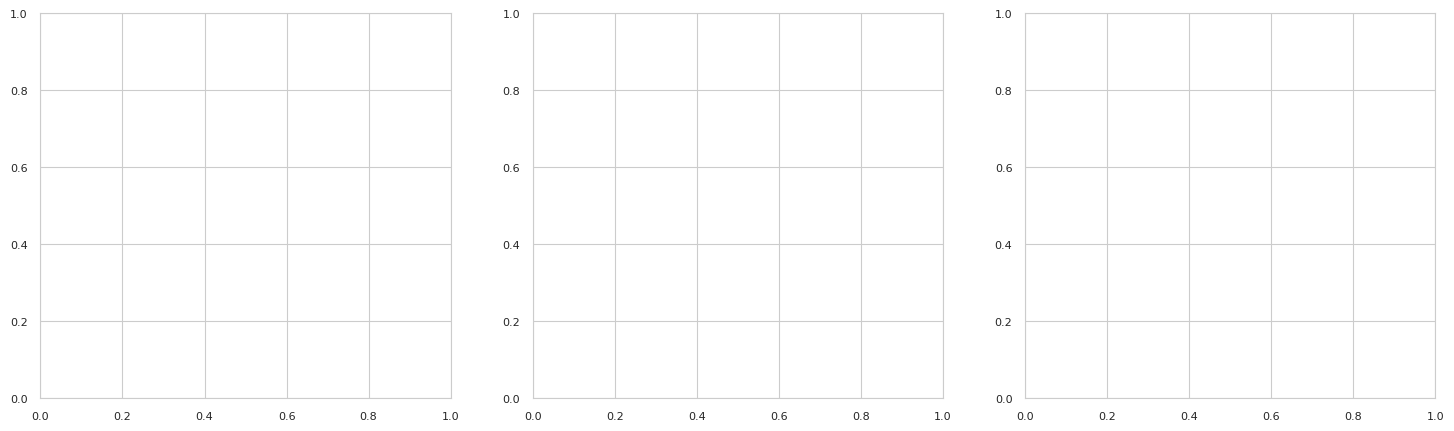

In [5]:

# ============================================================================
# EXPERIMENT 3: Combined Effects (Init + AuxLoss)
# Tests all combinations
#
# ============================================================================

print("\n" + "=" * 80)
print("EXPERIMENT 3: COMBINED EFFECTS (Initialization + Auxiliary Loss)")
print("=" * 80)

combined_results = defaultdict(list)

for dataset_name in ['mnist', 'olivetti', 'lfw']:
    print(f"\n### Processing {dataset_name.upper()} Dataset ###")

    config = experiment_configs[dataset_name]

    # Load data
    train_loader, test_loader, dataset_mean = load_data(
        dataset_name,
        batch_size=config['batch_size'],
        img_size=64
    )

    hidden_size = config['hidden_sizes'][0]  # Use middle size
    k_top = config['k_tops'][1]

    print(f"\nHidden Size: {hidden_size}, k_top: {k_top}")

    # Test all combinations
    model_configs = [
        ('SAE', 'None', 'None'),
        ('SAE_Init', 'Tied', 'None'),
        ('SAE_AuxLoss', 'None', 'AuxLoss'),
        ('Complete', 'Tied', 'AuxLoss')
    ]

    for model_type, init_type, aux_type in model_configs:
        print(f"  Training {model_type}...")

        set_seeds(42)

        # Train model
        model = train_sparse_autoencoder(
            train_loader=train_loader,
            num_epochs=config['num_epochs'],
            learning_rate=config['learning_rate'],
            input_size=config['input_size'],
            hidden_size=hidden_size,
            k_top=k_top,
            modelType=model_type,
            dataset_type=dataset_name,
            k_aux=2 * k_top if 'AuxLoss' in aux_type else None,
            k_aux_param=1 / 32,
            dead_feature_threshold=200,
            JumpReLU=0.1
        )



        # Evaluate
        test_loss_val = test_loss(model, test_loader, dataset_name)
        dead_neurons_count = count_dead_neurons(model, train_loader, dataset_name)
        activation_stats = get_activation_statistics(model, train_loader, dataset_name)

        # Store results
        combined_results['dataset'].append(dataset_name)
        combined_results['model_type'].append(model_type)
        combined_results['initialization'].append(init_type)
        combined_results['auxiliary_loss'].append(aux_type)
        combined_results['test_loss'].append(test_loss_val)
        combined_results['dead_neurons'].append(dead_neurons_count)
        combined_results['dead_neuron_pct'].append(100 * dead_neurons_count / hidden_size)
        combined_results['active_features'].append(activation_stats['active_features'])

        print(f"    Dead neurons: {dead_neurons_count}/{hidden_size} "
              f"({100 * dead_neurons_count / hidden_size:.2f}%)")

# Save results
df_combined = pd.DataFrame(combined_results)
df_combined.to_csv('experiment3_combined_effects_results.csv', index=False)
print("\nExperiment 3 results saved to 'experiment3_combined_effects_results.csv'")


In [8]:
import os

# Check if CSV files exist
required_files = [
    'experiment1_initialization_results.csv',
    'experiment2_auxiliary_loss_results.csv',
    'experiment3_combined_effects_results.csv'
]

for file in required_files:
    if not os.path.exists(file):
        raise FileNotFoundError(
            f"CSV file '{file}' not found. "
            f"Please run main() first to generate experiment results."
        )

# Load the dataframes
df_init = pd.read_csv('experiment1_initialization_results.csv')
df_aux = pd.read_csv('experiment2_auxiliary_loss_results.csv')
df_combined = pd.read_csv('experiment3_combined_effects_results.csv')

print(f"Loaded experiment results:")
print(f"  • df_init: {len(df_init)} rows, {len(df_init.columns)} columns")
print(f"  • df_aux: {len(df_aux)} rows, {len(df_aux.columns)} columns")
print(f"  • df_combined: {len(df_combined)} rows, {len(df_combined.columns)} columns")

# ============================================================================
# FIGURE GENERATION: Publication-Quality Plots
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING PUBLICATION-QUALITY FIGURES")
print("=" * 80)

# Set style for publication
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")

# Figure 1: Dead Neuron Percentage by Initialization Strategy
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, dataset in enumerate(['mnist', 'olivetti', 'lfw']):
    df_subset = df_init[df_init['dataset'] == dataset]

    # Group by initialization and hidden size
    pivot_data = df_subset.pivot_table(
        values='dead_neuron_pct',
        index='hidden_size',
        columns='initialization',
        aggfunc='mean'
    )

    pivot_data.plot(kind='bar', ax=axes[idx], width=0.8)
    axes[idx].set_title(f'{dataset.upper()} Dataset', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Hidden Size', fontsize=12)
    axes[idx].set_ylabel('Dead Neurons (%)', fontsize=12)
    axes[idx].legend(title='Initialization', fontsize=10)
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_ylim([0, 100])

plt.tight_layout()
plt.savefig('figure1_dead_neurons_by_initialization.png', dpi=300, bbox_inches='tight')
plt.savefig('figure1_dead_neurons_by_initialization.pdf', bbox_inches='tight')
print("Saved: figure1_dead_neurons_by_initialization.png/pdf")
plt.close()

# Figure 2: Auxiliary Loss Impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Dead neuron percentage
ax = axes[0]
df_aux_grouped = df_aux.groupby(['dataset', 'aux_loss'])['dead_neuron_pct'].mean().reset_index()
pivot_aux = df_aux_grouped.pivot(index='dataset', columns='aux_loss', values='dead_neuron_pct')
pivot_aux.plot(kind='bar', ax=ax, width=0.7, color=['#d62728', '#2ca02c'])
ax.set_title('Dead Neuron Percentage\nWith/Without Auxiliary Loss', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Dead Neurons (%)', fontsize=12)
ax.legend(title='Auxiliary Loss', fontsize=10)
ax.grid(axis='y', alpha=0.3)

# Panel B: Test loss comparison
ax = axes[1]
df_loss_grouped = df_aux.groupby(['dataset', 'aux_loss'])['test_loss'].mean().reset_index()
pivot_loss = df_loss_grouped.pivot(index='dataset', columns='aux_loss', values='test_loss')
pivot_loss.plot(kind='bar', ax=ax, width=0.7, color=['#d62728', '#2ca02c'])
ax.set_title('Reconstruction Loss\nWith/Without Auxiliary Loss', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Test Loss (MSE)', fontsize=12)
ax.legend(title='Auxiliary Loss', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figure2_auxiliary_loss_effects.png', dpi=300, bbox_inches='tight')
plt.savefig('figure2_auxiliary_loss_effects.pdf', bbox_inches='tight')
print("Saved: figure2_auxiliary_loss_effects.png/pdf")
plt.close()

# Figure 3: Combined Effects Summary
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Panel A: Dead neurons by model type
ax = axes[0, 0]
df_combined_grouped = df_combined.groupby(['dataset', 'model_type'])['dead_neuron_pct'].mean().reset_index()
pivot_combined = df_combined_grouped.pivot(index='dataset', columns='model_type', values='dead_neuron_pct')
pivot_combined.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Dead Neuron Percentage by Model Configuration', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Dead Neurons (%)', fontsize=12)
ax.legend(title='Model Type', fontsize=9, loc='upper right')
ax.grid(axis='y', alpha=0.3)

# Panel B: Test loss by model type
ax = axes[0, 1]
df_loss_combined = df_combined.groupby(['dataset', 'model_type'])['test_loss'].mean().reset_index()
pivot_loss_combined = df_loss_combined.pivot(index='dataset', columns='model_type', values='test_loss')
pivot_loss_combined.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Reconstruction Loss by Model Configuration', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Test Loss (MSE)', fontsize=12)
ax.legend(title='Model Type', fontsize=9, loc='upper right')
ax.grid(axis='y', alpha=0.3)

# Panel C: Scatter plot - Dead neurons vs Test loss
ax = axes[1, 0]
for model_type in df_combined['model_type'].unique():
    df_model = df_combined[df_combined['model_type'] == model_type]
    ax.scatter(df_model['dead_neuron_pct'], df_model['test_loss'],
               label=model_type, s=100, alpha=0.7)
ax.set_xlabel('Dead Neurons (%)', fontsize=12)
ax.set_ylabel('Test Loss (MSE)', fontsize=12)
ax.set_title('Dead Neurons vs Reconstruction Performance', fontsize=14, fontweight='bold')
ax.legend(title='Model Type', fontsize=9)
ax.grid(alpha=0.3)

# Panel D: Active features comparison
ax = axes[1, 1]
df_active = df_combined.groupby(['dataset', 'model_type'])['active_features'].mean().reset_index()
pivot_active = df_active.pivot(index='dataset', columns='model_type', values='active_features')
pivot_active.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Active Feature Count by Model Configuration', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset', fontsize=12)
ax.set_ylabel('Number of Active Features', fontsize=12)
ax.legend(title='Model Type', fontsize=9)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figure3_combined_effects_summary.png', dpi=300, bbox_inches='tight')
plt.savefig('figure3_combined_effects_summary.pdf', bbox_inches='tight')
print("Saved: figure3_combined_effects_summary.png/pdf")
plt.close()

# Figure 4: Activation Statistics Histograms
# Compare best vs worst configurations
print("\nGenerating activation histograms for best/worst models...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, dataset in enumerate(['mnist', 'olivetti', 'lfw']):
    print(f"  Processing {dataset}...")

    config = experiment_configs[dataset]
    train_loader, test_loader, dataset_mean = load_data(
        dataset,
        batch_size=config['batch_size'],
        img_size=64
    )

    hidden_size = config['hidden_sizes'][0]
    k_top = config['k_tops'][1]

    # Train baseline (worst) and complete (best) models
    set_seeds(42)
    model_baseline = train_sparse_autoencoder(
        train_loader, num_epochs=config['num_epochs'],
        learning_rate=config['learning_rate'],
        input_size=config['input_size'], hidden_size=hidden_size,
        k_top=k_top, modelType='SAE', dataset_type=dataset
    )

    set_seeds(42)
    model_complete = train_sparse_autoencoder(
        train_loader, num_epochs=config['num_epochs'],
        learning_rate=config['learning_rate'],
        input_size=config['input_size'], hidden_size=hidden_size,
        k_top=k_top, modelType='Complete', dataset_type=dataset,
        k_aux=2 * k_top, k_aux_param=1 / 32, dead_feature_threshold=1000,
        JumpReLU=0.1
    )

    # Get activation statistics
    stats_baseline = get_activation_statistics(model_baseline, train_loader, dataset)
    stats_complete = get_activation_statistics(model_complete, train_loader, dataset)

    # Plot histograms
    ax = axes[0, idx]
    ax.hist(stats_baseline['activation_frequencies'], bins=50, alpha=0.6,
            label='Baseline SAE', color='red', edgecolor='black')
    ax.hist(stats_complete['activation_frequencies'], bins=50, alpha=0.6,
            label='Complete SAE', color='green', edgecolor='black')
    ax.set_xlabel('Activation Frequency', fontsize=11)
    ax.set_ylabel('Number of Features', fontsize=11)
    ax.set_title(f'{dataset.upper()}: Activation Frequencies', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

    ax = axes[1, idx]
    active_base = stats_baseline['activation_strengths'][stats_baseline['activation_strengths'] > 0]
    active_complete = stats_complete['activation_strengths'][stats_complete['activation_strengths'] > 0]
    ax.hist(active_base, bins=50, alpha=0.6, label='Baseline SAE',
            color='red', edgecolor='black')
    ax.hist(active_complete, bins=50, alpha=0.6, label='Complete SAE',
            color='green', edgecolor='black')
    ax.set_xlabel('Mean Activation Strength', fontsize=11)
    ax.set_ylabel('Number of Features', fontsize=11)
    ax.set_title(f'{dataset.upper()}: Activation Strengths', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figure4_activation_histograms.png', dpi=300, bbox_inches='tight')
plt.savefig('figure4_activation_histograms.pdf', bbox_inches='tight')
print("Saved: figure4_activation_histograms.png/pdf")
plt.close()

# ============================================================================
# Generate Summary Statistics Table (LaTeX format)
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING SUMMARY STATISTICS TABLE")
print("=" * 80)

# Create comprehensive summary table
summary_stats = []

for dataset in ['mnist', 'olivetti', 'lfw']:
    for model_type in ['SAE', 'SAE_Init', 'SAE_AuxLoss', 'Complete']:
        df_subset = df_combined[
            (df_combined['dataset'] == dataset) &
            (df_combined['model_type'] == model_type)
            ]

        if len(df_subset) > 0:
            summary_stats.append({
                'Dataset': dataset.upper(),
                'Model': model_type,
                'Dead (%)': f"{df_subset['dead_neuron_pct'].mean():.2f} ± {df_subset['dead_neuron_pct'].std():.2f}",
                'Test Loss': f"{df_subset['test_loss'].mean():.6f} ± {df_subset['test_loss'].std():.6f}",
                'Active Features': f"{df_subset['active_features'].mean():.0f}"
            })

df_summary = pd.DataFrame(summary_stats)

# Save as CSV
df_summary.to_csv('summary_statistics.csv', index=False)
print("Saved: summary_statistics.csv")

# Save as LaTeX table
latex_table = df_summary.to_latex(index=False, escape=False, column_format='lllll')
with open('results/dead neurons/summary_statistics.tex', 'w') as f:
    f.write(latex_table)
print("Saved: summary_statistics.tex")

# Print to console
print("\nSummary Statistics:")
print(df_summary.to_string(index=False))

print("\n" + "=" * 80)
print("ALL EXPERIMENTS COMPLETED SUCCESSFULLY")
print("=" * 80)
print("\nGenerated Files:")
print("  - experiment1_initialization_results.csv")
print("  - experiment2_auxiliary_loss_results.csv")
print("  - experiment3_combined_effects_results.csv")
print("  - figure1_dead_neurons_by_initialization.png/pdf")
print("  - figure2_auxiliary_loss_effects.png/pdf")
print("  - figure3_combined_effects_summary.png/pdf")
print("  - figure4_activation_histograms.png/pdf")
print("  - summary_statistics.csv")
print("  - summary_statistics.tex")

Loaded experiment results:
  • df_init: 364 rows, 10 columns
  • df_aux: 14 rows, 9 columns
  • df_combined: 12 rows, 8 columns

GENERATING PUBLICATION-QUALITY FIGURES
Saved: figure1_dead_neurons_by_initialization.png/pdf
Saved: figure2_auxiliary_loss_effects.png/pdf
Saved: figure3_combined_effects_summary.png/pdf

Generating activation histograms for best/worst models...
  Processing mnist...
Epoch [1/50], Loss: 0.9370
Epoch [2/50], Loss: 0.5011
Epoch [3/50], Loss: 0.4658
Epoch [4/50], Loss: 0.4542
Epoch [5/50], Loss: 0.4495
Epoch [6/50], Loss: 0.4475
Epoch [7/50], Loss: 0.4462
Epoch [8/50], Loss: 0.4449
Epoch [9/50], Loss: 0.4433
Epoch [10/50], Loss: 0.4422
Epoch [11/50], Loss: 0.4415
Epoch [12/50], Loss: 0.4408
Epoch [13/50], Loss: 0.4402
Epoch [14/50], Loss: 0.4394
Epoch [15/50], Loss: 0.4387
Epoch [16/50], Loss: 0.4379
Epoch [17/50], Loss: 0.4372
Epoch [18/50], Loss: 0.4369
Epoch [19/50], Loss: 0.4364
Epoch [20/50], Loss: 0.4361
Epoch [21/50], Loss: 0.4359
Epoch [22/50], Loss: 0.4

In [10]:
#!/usr/bin/env python3
"""
Experiment 4: Effect of K on Reconstruction Quality and Parts-Based Representation
Investigates the sparsity-reconstruction tradeoff by varying k_top parameter
Includes both quantitative (MSE) and qualitative (interpretability) analysis
"""

import matplotlib

matplotlib.use('Agg')  # Non-interactive backend for cluster

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
from sklearn.datasets import fetch_olivetti_faces, fetch_lfw_people
from PIL import Image
import math
import os
import random


# ============================================================================
# REPRODUCIBILITY
# ============================================================================

def set_seeds(seed=42):
    """Set all random seeds for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# ============================================================================
# MODEL ARCHITECTURES
# ============================================================================

class SparseAutoencoder(nn.Module):
    """TopK Sparse Autoencoder"""

    def __init__(self, input_size=784, hidden_size=64, k_top=20):
        super(SparseAutoencoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.k_top = k_top
        self.name = f"TopK-SAE (k={k_top})"

        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)

        # Initialize with tied weights
        nn.init.kaiming_uniform_(self.encoder.weight, a=math.sqrt(5))
        with torch.no_grad():
            self.decoder.weight.copy_(self.encoder.weight.t())

    def _topk_mask(self, activations):
        k = max(0, min(self.k_top, activations.size(1)))
        _, idx = torch.topk(activations, k, dim=1)
        mask = torch.zeros_like(activations)
        mask.scatter_(1, idx, 1.0)
        return mask

    def forward(self, x):
        pre_activations = self.encoder(x)
        pre_activations = torch.nn.functional.relu(pre_activations)
        mask = self._topk_mask(pre_activations)
        h = pre_activations * mask
        x_hat = self.decoder(h)
        return h, x_hat

    def compute_loss(self, x, h, x_hat):
        recon_loss = torch.mean((x - x_hat) ** 2)
        return recon_loss


class CompleteAutoencoder(nn.Module):
    """Dense autoencoder (no sparsity) for comparison"""

    def __init__(self, input_size=784, hidden_size=64):
        super(CompleteAutoencoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.name = "Complete (No Sparsity)"

        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)

        nn.init.kaiming_uniform_(self.encoder.weight, a=math.sqrt(5))
        with torch.no_grad():
            self.decoder.weight.copy_(self.encoder.weight.t())

    def forward(self, x):
        h = torch.nn.functional.relu(self.encoder(x))
        x_hat = self.decoder(h)
        return h, x_hat

    def compute_loss(self, x, h, x_hat):
        return torch.mean((x - x_hat) ** 2)


# ============================================================================
# DATA LOADING
# ============================================================================

def load_mnist_data(batch_size=256):
    transform = transforms.Compose([transforms.ToTensor()])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


def load_olivetti_data(batch_size=32):
    faces = fetch_olivetti_faces(shuffle=True, random_state=42)
    data_tensor = torch.FloatTensor(faces.data)
    dataset = TensorDataset(data_tensor)

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    trainset, testset = random_split(dataset, [train_size, test_size],
                                     generator=torch.Generator().manual_seed(42))

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


def load_lfw_data(batch_size=128, img_size=64):
    lfw_people = fetch_lfw_people(min_faces_per_person=20, resize=1.0, color=False)

    resized_images = []
    for img in lfw_people.images:
        pil_img = Image.fromarray((img * 255).astype(np.uint8))
        pil_img = pil_img.resize((img_size, img_size), Image.LANCZOS)
        resized = np.array(pil_img).astype(np.float32) / 255.0
        resized_images.append(resized.flatten())

    data_tensor = torch.FloatTensor(np.array(resized_images))

    class LFWDataset(Dataset):
        def __init__(self, data):
            self.data = data

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return (self.data[idx],)

    dataset = LFWDataset(data_tensor)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    trainset, testset = random_split(dataset, [train_size, test_size],
                                     generator=torch.Generator().manual_seed(42))

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


# ============================================================================
# TRAINING AND EVALUATION
# ============================================================================

def train_model(model, train_loader, dataset_type, num_epochs=50, learning_rate=0.001):
    """Train sparse autoencoder"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data in train_loader:
            if dataset_type in ['olivetti', 'lfw']:
                inputs, = data
            else:
                inputs, _ = data

            inputs = inputs.to(device)
            if len(inputs.shape) == 4:
                inputs = inputs.view(inputs.size(0), -1)

            optimizer.zero_grad()
            h, outputs = model(inputs)
            loss = model.compute_loss(inputs, h, outputs)
            loss.backward()
            optimizer.step()

            # Enforce non-negativity
            with torch.no_grad():
                model.encoder.weight.clamp_(0.0)
                model.decoder.weight.clamp_(0.0)

            running_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f'  Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.6f}')

    return model


def compute_reconstruction_metrics(model, test_loader, dataset_type):
    """Compute MSE and L0 (average sparsity)"""
    device = next(model.parameters()).device
    model.eval()

    total_mse = 0.0
    total_l0 = 0.0
    total_samples = 0

    with torch.no_grad():
        for data in test_loader:
            if dataset_type in ['olivetti', 'lfw']:
                inputs, = data
            else:
                inputs, _ = data

            inputs = inputs.to(device)
            if len(inputs.shape) == 4:
                inputs = inputs.view(inputs.size(0), -1)

            h, x_hat = model(inputs)

            # MSE
            mse = torch.mean((inputs - x_hat) ** 2, dim=1)
            total_mse += mse.sum().item()

            # L0: number of active features per sample
            l0 = (h > 0).sum(dim=1).float()
            total_l0 += l0.sum().item()

            total_samples += inputs.size(0)

    avg_mse = total_mse / total_samples
    avg_l0 = total_l0 / total_samples

    return avg_mse, avg_l0


def compute_explained_variance(model, test_loader, dataset_type):
    """Compute explained variance (1 - MSE/Var(X))"""
    device = next(model.parameters()).device
    model.eval()

    all_inputs = []
    all_reconstructions = []

    with torch.no_grad():
        for data in test_loader:
            if dataset_type in ['olivetti', 'lfw']:
                inputs, = data
            else:
                inputs, _ = data

            inputs = inputs.to(device)
            if len(inputs.shape) == 4:
                inputs = inputs.view(inputs.size(0), -1)

            h, x_hat = model(inputs)

            all_inputs.append(inputs.cpu())
            all_reconstructions.append(x_hat.cpu())

    all_inputs = torch.cat(all_inputs, dim=0)
    all_reconstructions = torch.cat(all_reconstructions, dim=0)

    var_x = torch.var(all_inputs)
    mse = torch.mean((all_inputs - all_reconstructions) ** 2)
    explained_var = 1.0 - (mse / var_x)

    return explained_var.item()


# ============================================================================
# INTERPRETABILITY ANALYSIS
# ============================================================================
def visualize_decoder_features_grid(models_dict, dataset_name, test_loader, num_features_per_model=9):
    """
    Visualize ACTIVE decoder features for multiple models in a grid
    Each row shows features from one model (one K value)
    Only shows features that are actually active on test data
    """
    num_models = len(models_dict)

    fig, axes = plt.subplots(num_models, num_features_per_model,
                             figsize=(num_features_per_model * 2, num_models * 2.5))

    if num_models == 1:
        axes = axes.reshape(1, -1)

    # Determine image shape and dataset type
    if dataset_name == 'mnist':
        img_shape = (28, 28)
        dataset_type = 'mnist'
    elif dataset_name == 'olivetti':
        img_shape = (64, 64)
        dataset_type = 'olivetti'
    else:
        img_shape = (64, 64)
        dataset_type = 'lfw'

    # Process each model
    for row_idx, (model_name, model) in enumerate(sorted(models_dict.items())):
        device = next(model.parameters()).device
        model.eval()

        # Collect activations on test data to identify active features
        all_activations = []

        with torch.no_grad():
            for data in test_loader:
                if dataset_type in ['olivetti', 'lfw']:
                    inputs, = data
                else:
                    inputs, _ = data

                inputs = inputs.to(device)
                if len(inputs.shape) == 4:
                    inputs = inputs.view(inputs.size(0), -1)

                h, _ = model(inputs)
                all_activations.append(h.cpu())

        all_activations = torch.cat(all_activations, dim=0)  # (N_samples, hidden_size)

        # Identify active features (activated at least once)
        feature_activations = all_activations.sum(dim=0)  # Sum over all samples
        active_mask = feature_activations > 0
        active_indices = torch.where(active_mask)[0].numpy()

        num_active = len(active_indices)

        # Get decoder weights
        decoder_weights = model.decoder.weight.data.cpu().numpy()  # (input_size, hidden_size)

        # Select top active features by activation frequency
        if num_active > 0:
            active_feature_freqs = feature_activations[active_mask].numpy()
            # Sort by activation frequency (most frequently active first)
            sorted_active_idx = active_indices[np.argsort(active_feature_freqs)[::-1]]

            # Select top features to display
            num_to_display = min(num_features_per_model, len(sorted_active_idx))
            top_features = sorted_active_idx[:num_to_display]
        else:
            # Fallback: use highest norm features
            feature_norms = np.linalg.norm(decoder_weights, axis=0)
            top_features = np.argsort(feature_norms)[-num_features_per_model:][::-1]
            num_active = 0

        # Visualize selected features
        for col_idx in range(num_features_per_model):
            ax = axes[row_idx, col_idx]

            if col_idx < len(top_features):
                feature_idx = top_features[col_idx]
                feature_vector = decoder_weights[:, feature_idx]
                feature_img = feature_vector.reshape(img_shape)

                # Normalize for visualization
                feature_img = (feature_img - feature_img.min()) / (feature_img.max() - feature_img.min() + 1e-8)

                ax.imshow(feature_img, cmap='gray')
                ax.axis('off')

                # Add feature index label with activation frequency
                activation_freq = feature_activations[feature_idx].item()
                ax.set_title(f'F{feature_idx}\n({activation_freq:.0f}x)',
                            fontsize=8, pad=2)
            else:
                # Empty subplot if not enough active features
                ax.axis('off')

            # Add row label with k value and active feature count
            if col_idx == 0:
                if 'k=' in model_name:
                    k_val = model_name.split('k=')[1].split(')')[0]
                    label_text = f'k={k_val}\n({num_active} active)'
                else:
                    label_text = f'Dense\n({num_active} active)'

                ax.text(-0.15, 0.5, label_text,
                       transform=ax.transAxes,
                       fontsize=11, fontweight='bold',
                       rotation=0, va='center', ha='right')

    title = f'Active Learned Features Across Sparsity Levels\n{dataset_name.upper()} Dataset'
    plt.suptitle(title, fontsize=16, fontweight='bold', y=0.995)

    # Add subtitle explaining the visualization
    fig.text(0.5, 0.96,
            'Each row shows most frequently activated features for given sparsity level\n' +
            'Numbers in parentheses show activation frequency on test set',
            ha='center', fontsize=10, style='italic')

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    return fig


def compute_feature_interpretability_metrics(model, test_loader, dataset_type, top_k_examples=100):
    """
    Compute monosemanticity scores for all features
    Returns mean and std of monosemanticity across features
    """
    device = next(model.parameters()).device
    model.eval()

    # Collect all activations
    all_activations = []
    all_inputs = []

    with torch.no_grad():
        for data in test_loader:
            if dataset_type in ['olivetti', 'lfw']:
                inputs, = data
            else:
                inputs, _ = data

            inputs = inputs.to(device)
            if len(inputs.shape) == 4:
                inputs = inputs.view(inputs.size(0), -1)

            h, _ = model(inputs)

            all_activations.append(h.cpu())
            all_inputs.append(inputs.cpu())

    all_activations = torch.cat(all_activations, dim=0)  # (N, hidden_size)
    all_inputs = torch.cat(all_inputs, dim=0)  # (N, input_size)

    # For each feature, compute monosemanticity
    hidden_size = all_activations.size(1)
    monosemanticity_scores = []

    active_features = (all_activations.sum(dim=0) > 0).numpy()

    for feat_idx in range(hidden_size):
        if not active_features[feat_idx]:
            continue

        # Get activations for this feature
        feat_acts = all_activations[:, feat_idx]

        # Find top-k activating samples
        nonzero_mask = feat_acts > 0
        if nonzero_mask.sum() < 10:  # Too few activations
            continue

        nonzero_acts = feat_acts[nonzero_mask]
        nonzero_inputs = all_inputs[nonzero_mask]

        if len(nonzero_acts) < top_k_examples:
            top_k_actual = len(nonzero_acts)
        else:
            top_k_actual = top_k_examples

        top_k_indices = torch.argsort(nonzero_acts, descending=True)[:top_k_actual]
        top_inputs = nonzero_inputs[top_k_indices]

        # Compute pairwise cosine similarities
        similarities = torch.nn.functional.cosine_similarity(
            top_inputs.unsqueeze(1),
            top_inputs.unsqueeze(0),
            dim=2
        )

        # Average similarity (excluding diagonal)
        mask = ~torch.eye(similarities.size(0), dtype=torch.bool)
        avg_similarity = similarities[mask].mean().item()

        monosemanticity_scores.append(avg_similarity)

    if len(monosemanticity_scores) == 0:
        return 0.0, 0.0, 0

    return np.mean(monosemanticity_scores), np.std(monosemanticity_scores), len(monosemanticity_scores)


# ============================================================================
# EXPERIMENT 4: EFFECT OF K ON RECONSTRUCTION AND INTERPRETABILITY
# ============================================================================

def run_experiment_4():
    """
    Main experiment: Vary K and measure reconstruction quality + interpretability
    """
    print("=" * 80)
    print("EXPERIMENT 4: EFFECT OF K ON RECONSTRUCTION AND INTERPRETABILITY")
    print("=" * 80)

    # Configuration
    datasets = {
        'mnist': {'input_size': 784, 'batch_size': 256, 'img_shape': (28, 28)},
        'olivetti': {'input_size': 4096, 'batch_size': 32, 'img_shape': (64, 64)},
        'lfw': {'input_size': 4096, 'batch_size': 128, 'img_shape': (64, 64)}
    }

    hidden_size = 256
    num_epochs = 50
    learning_rate = 0.001

    # K values to test (sparsity levels from very sparse to dense)
    k_values = [5, 10, 20, 40, 64, 128, 256]  # 256 = dense (all features)

    results = defaultdict(list)
    trained_models = {}

    for dataset_name, config in datasets.items():
        print(f"\n{'=' * 80}")
        print(f"Processing {dataset_name.upper()} Dataset")
        print(f"{'=' * 80}")

        # Load data
        if dataset_name == 'mnist':
            train_loader, test_loader = load_mnist_data(config['batch_size'])
        elif dataset_name == 'olivetti':
            train_loader, test_loader = load_olivetti_data(config['batch_size'])
        else:
            train_loader, test_loader = load_lfw_data(config['batch_size'])

        dataset_models = {}

        # Train Complete model (no sparsity baseline)
        print(f"\nTraining Complete (Dense) Model...")
        set_seeds(42)
        complete_model = CompleteAutoencoder(input_size=config['input_size'],
                                             hidden_size=hidden_size)
        complete_model = train_model(complete_model, train_loader, dataset_name,
                                     num_epochs, learning_rate)

        mse, l0 = compute_reconstruction_metrics(complete_model, test_loader, dataset_name)
        explained_var = compute_explained_variance(complete_model, test_loader, dataset_name)
        mono_mean, mono_std, num_active = compute_feature_interpretability_metrics(
            complete_model, test_loader, dataset_name
        )

        results['dataset'].append(dataset_name)
        results['k'].append(hidden_size)  # All features active
        results['model_type'].append('Complete')
        results['mse'].append(mse)
        results['l0'].append(l0)
        results['explained_variance'].append(explained_var)
        results['monosemanticity_mean'].append(mono_mean)
        results['monosemanticity_std'].append(mono_std)
        results['num_active_features'].append(num_active)

        dataset_models['Complete'] = complete_model

        print(f"  MSE: {mse:.6f}, L0: {l0:.2f}, Explained Var: {explained_var:.4f}")
        print(f"  Monosemanticity: {mono_mean:.4f} ± {mono_std:.4f} ({num_active} features)")

        # Train TopK SAE for each K value
        for k in k_values:
            if k >= hidden_size:
                continue  # Skip if k >= hidden_size

            print(f"\nTraining TopK-SAE with k={k}...")
            set_seeds(42)

            model = SparseAutoencoder(input_size=config['input_size'],
                                      hidden_size=hidden_size,
                                      k_top=k)
            model = train_model(model, train_loader, dataset_name, num_epochs, learning_rate)

            # Evaluate
            mse, l0 = compute_reconstruction_metrics(model, test_loader, dataset_name)
            explained_var = compute_explained_variance(model, test_loader, dataset_name)
            mono_mean, mono_std, num_active = compute_feature_interpretability_metrics(
                model, test_loader, dataset_name
            )

            results['dataset'].append(dataset_name)
            results['k'].append(k)
            results['model_type'].append('TopK-SAE')
            results['mse'].append(mse)
            results['l0'].append(l0)
            results['explained_variance'].append(explained_var)
            results['monosemanticity_mean'].append(mono_mean)
            results['monosemanticity_std'].append(mono_std)
            results['num_active_features'].append(num_active)

            dataset_models[f'k={k}'] = model

            print(f"  MSE: {mse:.6f}, L0: {l0:.2f}, Explained Var: {explained_var:.4f}")
            print(f"  Monosemanticity: {mono_mean:.4f} ± {mono_std:.4f} ({num_active} features)")

        # Store models for visualization
        trained_models[dataset_name] = dataset_models

    # Save results
    df = pd.DataFrame(results)
    df.to_csv('experiment4_k_effects_results.csv', index=False)
    print("\n✓ Results saved to 'experiment4_k_effects_results.csv'")

    return df, trained_models


# ============================================================================
# VISUALIZATION
# ============================================================================

def create_comprehensive_figures(df, trained_models):
    """Create publication-quality figures"""

    # Figure 1: Sparsity-Reconstruction Tradeoff (L0 vs MSE)
    print("\nGenerating Figure 1: Sparsity-Reconstruction Tradeoff...")
    fig1, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, dataset in enumerate(['mnist', 'olivetti', 'lfw']):
        df_dataset = df[df['dataset'] == dataset]

        # Plot TopK points
        topk_data = df_dataset[df_dataset['model_type'] == 'TopK-SAE']
        axes[idx].plot(topk_data['l0'], topk_data['mse'],
                       'o-', linewidth=2, markersize=8,
                       label='TopK-SAE', color='steelblue')

        # Plot Complete point
        complete_data = df_dataset[df_dataset['model_type'] == 'Complete']
        axes[idx].plot(complete_data['l0'], complete_data['mse'],
                       's', markersize=12, label='Dense (No Sparsity)',
                       color='coral', zorder=10)

        # Annotate K values
        for _, row in topk_data.iterrows():
            axes[idx].annotate(f"k={int(row['k'])}",
                               (row['l0'], row['mse']),
                               textcoords="offset points",
                               xytext=(0, 10), ha='center', fontsize=8)

        axes[idx].set_xlabel('Average L0 (Active Features)', fontsize=12)
        axes[idx].set_ylabel('MSE (Test)', fontsize=12)
        axes[idx].set_title(f'{dataset.upper()}', fontsize=14, fontweight='bold')
        axes[idx].legend(fontsize=10)
        axes[idx].grid(alpha=0.3)

    plt.tight_layout()
    fig1.savefig('figure_exp4_1_sparsity_reconstruction_tradeoff.png', dpi=300, bbox_inches='tight')
    fig1.savefig('figure_exp4_1_sparsity_reconstruction_tradeoff.pdf', bbox_inches='tight')
    print("  ✓ Saved: figure_exp4_1_sparsity_reconstruction_tradeoff.png/pdf")

    # Figure 2: Explained Variance vs Sparsity
    print("\nGenerating Figure 2: Explained Variance vs Sparsity...")
    fig2, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, dataset in enumerate(['mnist', 'olivetti', 'lfw']):
        df_dataset = df[df['dataset'] == dataset]

        topk_data = df_dataset[df_dataset['model_type'] == 'TopK-SAE']
        axes[idx].plot(topk_data['k'], topk_data['explained_variance'],
                       'o-', linewidth=2, markersize=8,
                       label='TopK-SAE', color='forestgreen')

        complete_data = df_dataset[df_dataset['model_type'] == 'Complete']
        axes[idx].axhline(complete_data['explained_variance'].values[0],
                          linestyle='--', color='coral', linewidth=2,
                          label='Dense Baseline')

        axes[idx].set_xlabel('K (Sparsity Level)', fontsize=12)
        axes[idx].set_ylabel('Explained Variance', fontsize=12)
        axes[idx].set_title(f'{dataset.upper()}', fontsize=14, fontweight='bold')
        axes[idx].legend(fontsize=10)
        axes[idx].grid(alpha=0.3)
        axes[idx].set_xscale('log')

    plt.tight_layout()
    fig2.savefig('figure_exp4_2_explained_variance.png', dpi=300, bbox_inches='tight')
    fig2.savefig('figure_exp4_2_explained_variance.pdf', bbox_inches='tight')
    print("  ✓ Saved: figure_exp4_2_explained_variance.png/pdf")

    # Figure 3: Monosemanticity vs Sparsity
    print("\nGenerating Figure 3: Monosemanticity vs Sparsity...")
    fig3, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, dataset in enumerate(['mnist', 'olivetti', 'lfw']):
        df_dataset = df[df['dataset'] == dataset]

        topk_data = df_dataset[df_dataset['model_type'] == 'TopK-SAE']
        axes[idx].errorbar(topk_data['k'], topk_data['monosemanticity_mean'],
                           yerr=topk_data['monosemanticity_std'],
                           fmt='o-', linewidth=2, markersize=8, capsize=5,
                           label='TopK-SAE', color='purple')

        complete_data = df_dataset[df_dataset['model_type'] == 'Complete']
        axes[idx].axhline(complete_data['monosemanticity_mean'].values[0],
                          linestyle='--', color='coral', linewidth=2,
                          label='Dense Baseline')

        axes[idx].set_xlabel('K (Sparsity Level)', fontsize=12)
        axes[idx].set_ylabel('Monosemanticity Score', fontsize=12)
        axes[idx].set_title(f'{dataset.upper()}', fontsize=14, fontweight='bold')
        axes[idx].legend(fontsize=10)
        axes[idx].grid(alpha=0.3)
        axes[idx].set_xscale('log')

    plt.tight_layout()
    fig3.savefig('figure_exp4_3_monosemanticity.png', dpi=300, bbox_inches='tight')
    fig3.savefig('figure_exp4_3_monosemanticity.pdf', bbox_inches='tight')
    print("  ✓ Saved: figure_exp4_3_monosemanticity.png/pdf")

    # Figure 4: Decoder Feature Visualization Grid
    # Need to reload test data for visualization
    datasets_config = {
        'mnist': {'batch_size': 256},
        'olivetti': {'batch_size': 32},
        'lfw': {'batch_size': 128}
    }
    print("\nGenerating Figure 4: Decoder Feature Visualizations...")
    for dataset_name, models_dict in trained_models.items():
        # Get test_loader for this dataset
        if dataset_name == 'mnist':
            _, test_loader = load_mnist_data(datasets_config[dataset_name]['batch_size'])
        elif dataset_name == 'olivetti':
            _, test_loader = load_olivetti_data(datasets_config[dataset_name]['batch_size'])
        else:  # lfw
            _, test_loader = load_lfw_data(datasets_config[dataset_name]['batch_size'])

        # Generate visualization with test data
        fig = visualize_decoder_features_grid(models_dict, dataset_name, test_loader,
                                              num_features_per_model=9)
        fig.savefig(f'figure_exp4_4_features_{dataset_name}.png', dpi=300, bbox_inches='tight')
        fig.savefig(f'figure_exp4_4_features_{dataset_name}.pdf', bbox_inches='tight')
        print(f"  ✓ Saved: figure_exp4_4_features_{dataset_name}.png/pdf")
        plt.close(fig)

    # Figure 5: Combined Multi-Panel Summary
    print("\nGenerating Figure 5: Comprehensive Summary...")
    fig5 = plt.figure(figsize=(20, 12))
    gs = fig5.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # Row 1: Sparsity-Reconstruction Tradeoff
    for col, dataset in enumerate(['mnist', 'olivetti', 'lfw']):
        ax = fig5.add_subplot(gs[0, col])
        df_dataset = df[df['dataset'] == dataset]
        topk_data = df_dataset[df_dataset['model_type'] == 'TopK-SAE']
        complete_data = df_dataset[df_dataset['model_type'] == 'Complete']

        ax.plot(topk_data['l0'], topk_data['mse'], 'o-', linewidth=2, markersize=8)
        ax.plot(complete_data['l0'], complete_data['mse'], 's', markersize=12, color='coral')
        ax.set_xlabel('L0 (Active Features)', fontsize=10)
        ax.set_ylabel('MSE', fontsize=10)
        ax.set_title(f'{dataset.upper()}: MSE vs L0', fontsize=11, fontweight='bold')
        ax.grid(alpha=0.3)

    # Row 2: Monosemanticity
    for col, dataset in enumerate(['mnist', 'olivetti', 'lfw']):
        ax = fig5.add_subplot(gs[1, col])
        df_dataset = df[df['dataset'] == dataset]
        topk_data = df_dataset[df_dataset['model_type'] == 'TopK-SAE']

        ax.plot(topk_data['k'], topk_data['monosemanticity_mean'],
                'o-', linewidth=2, markersize=8, color='purple')
        ax.set_xlabel('K (Sparsity)', fontsize=10)
        ax.set_ylabel('Monosemanticity', fontsize=10)
        ax.set_title(f'{dataset.upper()}: Interpretability', fontsize=11, fontweight='bold')
        ax.set_xscale('log')
        ax.grid(alpha=0.3)

    # Row 3: Reconstruction Quality vs Interpretability Trade-off
    for col, dataset in enumerate(['mnist', 'olivetti', 'lfw']):
        ax = fig5.add_subplot(gs[2, col])
        df_dataset = df[df['dataset'] == dataset]
        topk_data = df_dataset[df_dataset['model_type'] == 'TopK-SAE']

        scatter = ax.scatter(topk_data['mse'], topk_data['monosemanticity_mean'],
                             c=topk_data['k'], cmap='viridis', s=100, alpha=0.7)

        # Annotate k values
        for _, row in topk_data.iterrows():
            ax.annotate(f"{int(row['k'])}", (row['mse'], row['monosemanticity_mean']),
                        fontsize=8, ha='center')

        ax.set_xlabel('MSE (Lower = Better)', fontsize=10)
        ax.set_ylabel('Monosemanticity (Higher = Better)', fontsize=10)
        ax.set_title(f'{dataset.upper()}: Quality vs Interpretability', fontsize=11, fontweight='bold')
        ax.grid(alpha=0.3)

        if col == 2:
            cbar = plt.colorbar(scatter, ax=ax)
            cbar.set_label('K (Sparsity)', fontsize=10)

    plt.suptitle('Effect of K on Reconstruction and Interpretability',
                 fontsize=16, fontweight='bold', y=0.995)

    fig5.savefig('figure_exp4_5_comprehensive_summary.png', dpi=300, bbox_inches='tight')
    fig5.savefig('figure_exp4_5_comprehensive_summary.pdf', bbox_inches='tight')
    print("  ✓ Saved: figure_exp4_5_comprehensive_summary.png/pdf")


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("=" * 80)
    print("SPARSE AUTOENCODER: EFFECT OF K ON RECONSTRUCTION AND INTERPRETABILITY")
    print("=" * 80)

    # Run experiment
    df, trained_models = run_experiment_4()

    # Create figures
    create_comprehensive_figures(df, trained_models)

    print("\n" + "=" * 80)
    print("EXPERIMENT 4 COMPLETE!")
    print("=" * 80)
    print("\nGenerated files:")
    print("- experiment4_k_effects_results.csv")
    print("- figure_exp4_1_sparsity_reconstruction_tradeoff.png/pdf")
    print("- figure_exp4_2_explained_variance.png/pdf")
    print("- figure_exp4_3_monosemanticity.png/pdf")
    print("- figure_exp4_4_features_mnist.png/pdf")
    print("- figure_exp4_4_features_olivetti.png/pdf")
    print("- figure_exp4_4_features_lfw.png/pdf")
    print("- figure_exp4_5_comprehensive_summary.png/pdf")
    print("=" * 80)


SPARSE AUTOENCODER: EFFECT OF K ON RECONSTRUCTION AND INTERPRETABILITY
EXPERIMENT 4: EFFECT OF K ON RECONSTRUCTION AND INTERPRETABILITY

Processing MNIST Dataset

Training Complete (Dense) Model...
  Epoch [10/50], Loss: 0.012615
  Epoch [20/50], Loss: 0.005401
  Epoch [30/50], Loss: 0.003446
  Epoch [40/50], Loss: 0.002913
  Epoch [50/50], Loss: 0.002793
  MSE: 0.002707, L0: 115.97, Explained Var: 0.9719
  Monosemanticity: 0.5400 ± 0.0489 (256 features)

Training TopK-SAE with k=5...
  Epoch [10/50], Loss: 0.027739
  Epoch [20/50], Loss: 0.027263
  Epoch [30/50], Loss: 0.027189
  Epoch [40/50], Loss: 0.027192
  Epoch [50/50], Loss: 0.026843
  MSE: 0.028696, L0: 5.00, Explained Var: 0.7023
  Monosemanticity: 0.6754 ± 0.0850 (84 features)

Training TopK-SAE with k=10...
  Epoch [10/50], Loss: 0.020553
  Epoch [20/50], Loss: 0.020176
  Epoch [30/50], Loss: 0.019982
  Epoch [40/50], Loss: 0.019903
  Epoch [50/50], Loss: 0.019854
  MSE: 0.019862, L0: 10.00, Explained Var: 0.7940
  Monosema